In [1]:
# Kết nối Google Drive (nếu chạy trong Colab)
try:
    from google.colab import drive
    print("Kết nối Google Drive...")
    drive.mount('/content/drive')
except:
    print("Không thể kết nối Google Drive hoặc không chạy trong môi trường Colab.")

Kết nối Google Drive...
Mounted at /content/drive


In [2]:
import numpy as np
import scipy.io as sio
import os
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from scipy import signal

# **Preprocess data**

In [3]:
# Sửa đường dẫn để phù hợp với vị trí thực tế của file
data_path = '/content/drive/MyDrive/cuoiky/bidmc/bidmc_data.mat'  # Sử dụng đường dẫn tương đối thay vì tuyệt đối

# Tạo thư mục figures nếu chưa tồn tại
figures_path = 'figures'
# Đường dẫn dữ liệu

processed_path = '/content/drive/MyDrive/cuoiky/bidmc/processed/'

os.makedirs(processed_path, exist_ok=True)
os.makedirs(figures_path, exist_ok=True)

# Tải dữ liệu
print("Đang tải dữ liệu từ file .mat...")
mat_data = sio.loadmat(data_path)
data = mat_data['data'][0]  # 53 bản ghi
print(f"Số lượng bản ghi: {len(data)}")

# Tham số
fs = 125  # Tần số lấy mẫu (Hz)
segment_length = 750  # 6 giây (750 mẫu) - Đã thay đổi từ 1250 xuống 750
overlap = 0.5  # 50% chồng lấp

Đang tải dữ liệu từ file .mat...
Số lượng bản ghi: 53


In [4]:
# Hàm kiểm tra và trích xuất mảng phẳng
def extract_flat_array(data, field='v', record_idx=None):
    try:
        if hasattr(data, 'dtype') and data.dtype.names is not None and field in data.dtype.names:
            values = data[field]
            print(f"- Bản ghi {record_idx}: Tìm thấy trường '{field}', shape ban đầu: {values.shape}")
        else:
            values = data
            print(f"- Bản ghi {record_idx}: Không có trường '{field}', shape ban đầu: {values.shape}")

        # Kiểm tra nội dung
        print(f"- Nội dung của '{field}' (5 phần tử đầu): {values[:5]}")

        # Xử lý mảng lồng nhau
        if values.size == 1 and isinstance(values[0], np.ndarray):
            flat_values = values[0].flatten()
            print(f"- Phát hiện mảng lồng nhau, shape sau khi trích xuất: {flat_values.shape}")
        else:
            flat_values = values.flatten()

        if len(flat_values) == 0:
            raise ValueError("Mảng trống sau khi flatten")

        # Kiểm tra giá trị nan
        if np.any(np.isnan(flat_values)):
            raise ValueError(f"Mảng chứa giá trị nan: {flat_values[:5]}...")

        return flat_values.astype(float)
    except Exception as e:
        raise ValueError(f"Lỗi trích xuất: {e}")

In [5]:
# Tiền xử lý dữ liệu
ppg_segments = []
hr_raw_segments = []
valid_records = 0

# Thu thập tất cả giá trị HR để tính mean và std
all_hr_values = []

# Bước 1: Thu thập tất cả giá trị HR từ các bản ghi
for i, record in enumerate(data):
    try:
        # Trích xuất HR
        params = record['ref'][0, 0]['params'][0, 0]
        hr_values = extract_flat_array(params['hr'][0], 'v', i)

        if len(hr_values) > 0:
            all_hr_values.extend(hr_values)
    except Exception as e:
        print(f"- Lỗi khi thu thập HR từ bản ghi {i}: {e}")

# Tính mean và std cho HR
hr_mean = np.mean(all_hr_values)
hr_std = np.std(all_hr_values)

# Xác định phạm vi HR (min và max của toàn bộ dữ liệu)
HR_MIN = np.min(all_hr_values)
HR_MAX = np.max(all_hr_values)

print(f"\nThống kê HR:")
print(f"- HR: mean = {hr_mean:.2f}, std = {hr_std:.2f}, phạm vi = [{HR_MIN:.2f}, {HR_MAX:.2f}]")

- Bản ghi 0: Tìm thấy trường 'v', shape ban đầu: (1,)
- Nội dung của 'v' (5 phần tử đầu): [array([[94],
        [94],
        [94],
        [92],
        [93],
        [93],
        [94],
        [94],
        [94],
        [94],
        [94],
        [94],
        [94],
        [94],
        [94],
        [95],
        [94],
        [94],
        [94],
        [94],
        [94],
        [94],
        [94],
        [94],
        [94],
        [94],
        [94],
        [94],
        [94],
        [94],
        [94],
        [94],
        [94],
        [93],
        [93],
        [93],
        [93],
        [93],
        [92],
        [92],
        [92],
        [92],
        [92],
        [92],
        [92],
        [95],
        [95],
        [92],
        [92],
        [92],
        [92],
        [92],
        [92],
        [91],
        [89],
        [91],
        [91],
        [91],
        [91],
        [91],
        [90],
        [90],
        [90],
        [90],
        [90],



Xử lý bản ghi 0:
- Độ dài tín hiệu PPG gốc: 60001 mẫu (480.01 giây)
- Bản ghi 0: Tìm thấy trường 'v', shape ban đầu: (1,)
- Nội dung của 'v' (5 phần tử đầu): [array([[94],
        [94],
        [94],
        [92],
        [93],
        [93],
        [94],
        [94],
        [94],
        [94],
        [94],
        [94],
        [94],
        [94],
        [94],
        [95],
        [94],
        [94],
        [94],
        [94],
        [94],
        [94],
        [94],
        [94],
        [94],
        [94],
        [94],
        [94],
        [94],
        [94],
        [94],
        [94],
        [94],
        [93],
        [93],
        [93],
        [93],
        [93],
        [92],
        [92],
        [92],
        [92],
        [92],
        [92],
        [92],
        [95],
        [95],
        [92],
        [92],
        [92],
        [92],
        [92],
        [92],
        [91],
        [89],
        [91],
        [91],
        [91],
        [91],
        [91],
 

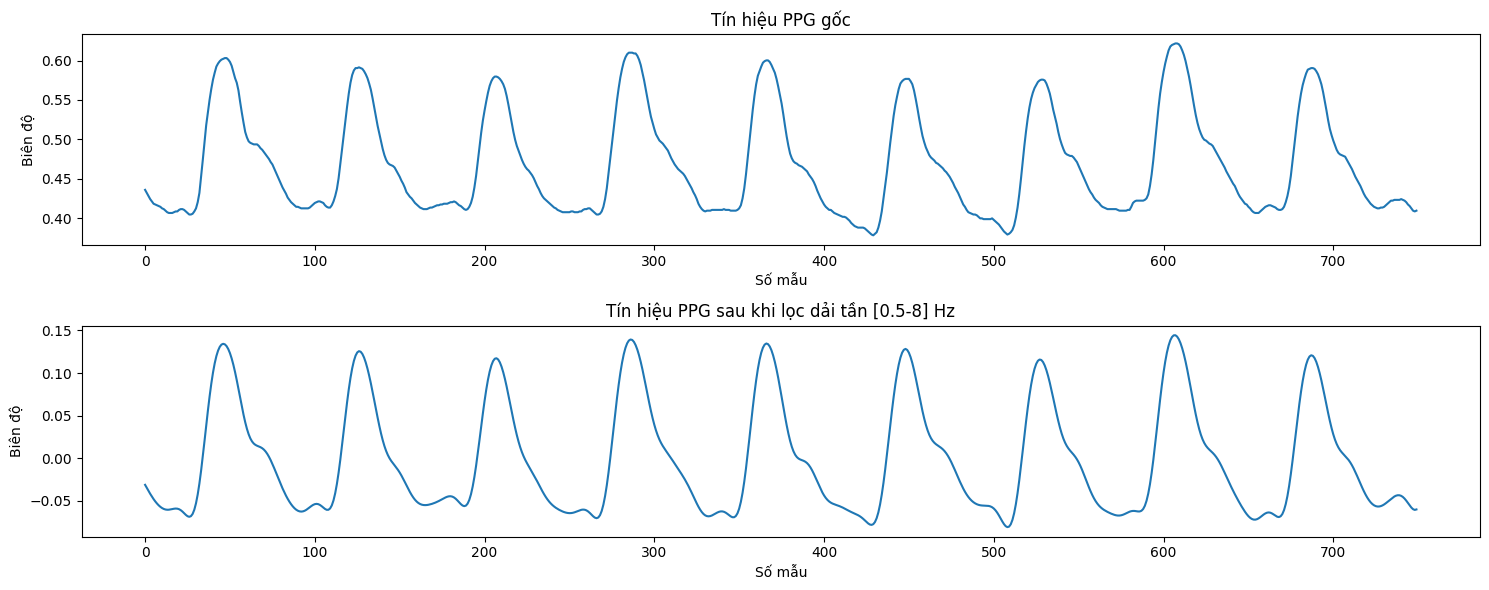

Streaming output truncated to the last 5000 lines.
        [85],
        [83],
        [82],
        [80],
        [79],
        [79],
        [80],
        [81],
        [81],
        [83],
        [84],
        [85],
        [86],
        [87],
        [87],
        [88],
        [88],
        [88],
        [89],
        [89],
        [89],
        [89],
        [89],
        [90],
        [90],
        [91],
        [91],
        [91],
        [91],
        [92],
        [92],
        [93],
        [94],
        [94],
        [94],
        [94],
        [95],
        [94],
        [93],
        [93],
        [92],
        [92],
        [93],
        [93],
        [94],
        [96],
        [96],
        [97],
        [97],
        [97],
        [96],
        [96],
        [95],
        [94],
        [93],
        [93],
        [92],
        [92],
        [93],
        [93],
        [94],
        [94],
        [95],
        [96],
        [96],
        [97],
        [96],
        [96

In [6]:
# Bước 2: Xử lý dữ liệu với phạm vi HR đã xác định
for i, record in enumerate(data):
    try:
        # Trích xuất tín hiệu PPG
        ppg = record['ppg'][0, 0]['v'].flatten()
        print(f"\nXử lý bản ghi {i}:")
        print(f"- Độ dài tín hiệu PPG gốc: {len(ppg)} mẫu ({len(ppg)/fs:.2f} giây)")

        # Trích xuất HR
        params = record['ref'][0, 0]['params'][0, 0]
        hr_values = extract_flat_array(params['hr'][0], 'v', i)

        # Kiểm tra dữ liệu HR
        if len(hr_values) < 2:
            print(f"- Không đủ dữ liệu HR cho bản ghi {i} (HR: {len(hr_values)}), bỏ qua")
            continue

        print(f"- Số giá trị HR gốc: {len(hr_values)}, Giá trị đầu tiên: {hr_values[0]:.2f}")

        # Lọc tín hiệu PPG trong dải tần [0.5-8] Hz
        nyquist = fs / 2
        low_cutoff = 0.5 / nyquist
        high_cutoff = 8.0 / nyquist
        b, a = signal.butter(4, [low_cutoff, high_cutoff], btype='band')
        ppg_filtered = signal.filtfilt(b, a, ppg)

        # Vẽ so sánh tín hiệu PPG gốc và sau khi lọc
        plt.figure(figsize=(15, 6))

        # Vẽ tín hiệu PPG gốc
        plt.subplot(2, 1, 1)
        plt.plot(ppg[:750])  # Hiển thị 750 mẫu đầu tiên
        plt.title('Tín hiệu PPG gốc')
        plt.xlabel('Số mẫu')
        plt.ylabel('Biên độ')

        # Vẽ tín hiệu PPG sau khi lọc
        plt.subplot(2, 1, 2)
        plt.plot(ppg_filtered[:750])  # Hiển thị 750 mẫu đầu tiên
        plt.title('Tín hiệu PPG sau khi lọc dải tần [0.5-8] Hz')
        plt.xlabel('Số mẫu')
        plt.ylabel('Biên độ')

        plt.tight_layout()
        plt.savefig(os.path.join(figures_path, f'ppg_filter_comparison_record_{i}.png'))
        if i == 0:  # Chỉ hiển thị hình vẽ cho bản ghi đầu tiên
            plt.show()
        else:
            plt.close()

        # Phân đoạn tín hiệu
        step = int(segment_length * (1 - overlap))
        num_segments = (len(ppg) - segment_length) // step + 1
        print(f"- Số đoạn tín hiệu: {num_segments}")

        hr_fs = len(hr_values) / (len(ppg) / fs)  # Tần số lấy mẫu của HR

        for j in range(num_segments):
            start = j * step
            end = start + segment_length

            if end <= len(ppg):
                # Lấy đoạn tín hiệu PPG đã lọc
                ppg_seg = ppg_filtered[start:end]

                # Chuẩn hóa từng đoạn PPG về [-1, 1]
                scaler = MinMaxScaler(feature_range=(-1, 1))
                ppg_seg_normalized = scaler.fit_transform(ppg_seg.reshape(-1, 1)).flatten()

                hr_start_idx = int(start / fs * hr_fs)
                hr_end_idx = min(int(end / fs * hr_fs), len(hr_values))

                hr_raw_seg = np.mean(hr_values[hr_start_idx:hr_end_idx]) if hr_end_idx > hr_start_idx else hr_values[hr_start_idx]

                if np.isnan(hr_raw_seg):
                    print(f"- Lỗi: Đoạn {j} chứa nan (HR: {hr_raw_seg})")
                    continue

                # Lấy tất cả các đoạn
                ppg_segments.append(ppg_seg_normalized)
                hr_raw_segments.append(hr_raw_seg)

        valid_records += 1
        print(f"- Đã xử lý thành công bản ghi {i}")

    except Exception as e:
        print(f"- Lỗi khi xử lý bản ghi {i}: {e}")

# Chuyển thành mảng numpy
ppg_segments = np.array(ppg_segments)
hr_raw_segments = np.array(hr_raw_segments)

In [7]:
# Kiểm tra dữ liệu
print(f"\nTổng kết tiền xử lý:")
print(f"- Số bản ghi xử lý thành công: {valid_records}/{len(data)}")
print(f"- Tổng số đoạn tín hiệu: {len(ppg_segments)}")
if len(ppg_segments) == 0:
    print("Không có dữ liệu hợp lệ. Tạo dữ liệu giả lập để minh họa.")
    num_samples = 100
    ppg_segments = np.random.rand(num_samples, segment_length)
    hr_raw_segments = np.random.uniform(HR_MIN, HR_MAX, num_samples)
    print(f"- Đã tạo {num_samples} mẫu dữ liệu giả lập.")


Tổng kết tiền xử lý:
- Số bản ghi xử lý thành công: 52/53
- Tổng số đoạn tín hiệu: 8268


In [8]:
# Chia dữ liệu thành train/test (80/20)
train_size = int(0.8 * len(ppg_segments))
indices = np.random.permutation(len(ppg_segments))
train_indices = indices[:train_size]
test_indices = indices[train_size:]

X_train = ppg_segments[train_indices]
X_test = ppg_segments[test_indices]
hr_raw_train = hr_raw_segments[train_indices]
hr_raw_test = hr_raw_segments[test_indices]

# Chuẩn hóa dữ liệu X_train và X_test
X_train_norm = X_train.copy()  # Đã chuẩn hóa từng đoạn rồi
X_test_norm = X_test.copy()    # Đã chuẩn hóa từng đoạn rồi

# Tạo X_total_norm và hr_total_norm
X_total_norm = np.vstack((X_train_norm, X_test_norm))
hr_raw_total = np.concatenate((hr_raw_train, hr_raw_test))

# In shape của dữ liệu tổng hợp
print(f"\nDữ liệu tổng hợp:")
print(f"- X_total_norm shape: {X_total_norm.shape}")
print(f"- hr_raw_total shape: {hr_raw_total.shape}")


Dữ liệu tổng hợp:
- X_total_norm shape: (8268, 750)
- hr_raw_total shape: (8268,)


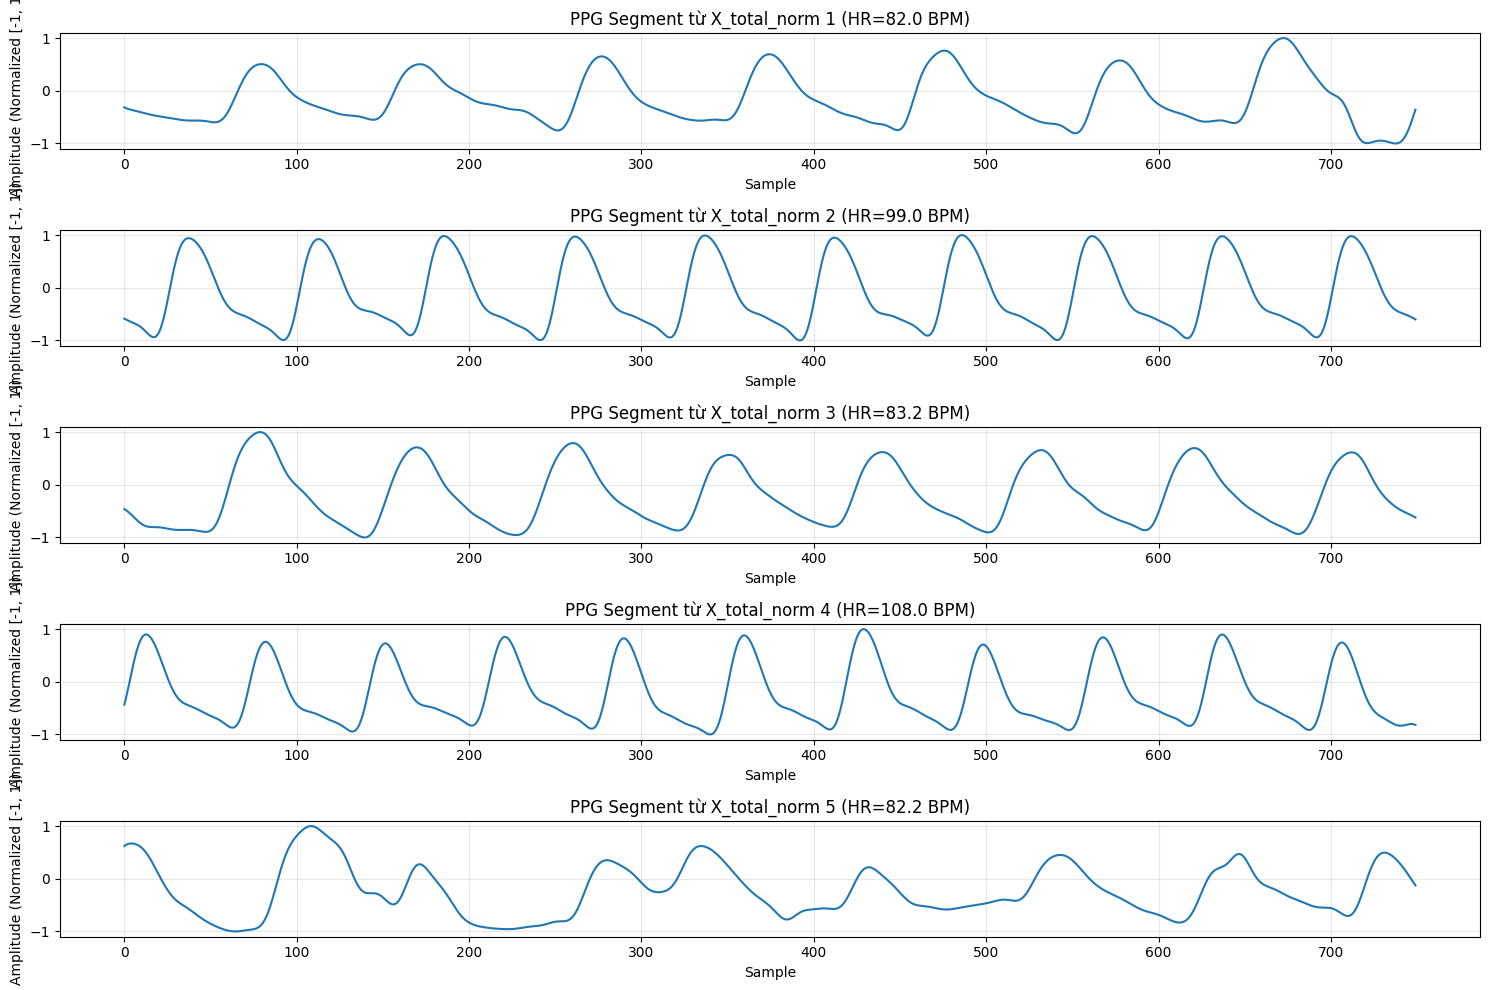

In [9]:
# Vẽ một vài mẫu từ X_total để kiểm tra
plt.figure(figsize=(15, 10))
for i in range(min(5, len(X_total_norm))):
    plt.subplot(5, 1, i+1)
    plt.plot(X_total_norm[i])
    plt.title(f'PPG Segment từ X_total_norm {i+1} (HR={hr_raw_total[i]:.1f} BPM)')
    plt.xlabel('Sample')
    plt.ylabel('Amplitude (Normalized [-1, 1])')
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(figures_path, 'X_total_norm_samples.png'))
plt.show()

In [10]:
# Lưu dữ liệu đã xử lý vào file .mat
import scipy.io as sio

# Tạo dictionary chứa tất cả dữ liệu cần lưu
data_to_save = {
    'X_train_norm': X_train_norm,
    'X_test_norm': X_test_norm,
    'hr_raw_train': hr_raw_train,
    'hr_raw_test': hr_raw_test,
    'X_total_norm': X_total_norm,
    'hr_raw_total': hr_raw_total
}

# Lưu vào file .mat
sio.savemat('processed_bidmc_data.mat', data_to_save)
print("Đã lưu dữ liệu vào file 'processed_bidmc_data.mat'")

# In kích thước dữ liệu
print(f"- Kích thước tập huấn luyện: {X_train.shape}")
print(f"- Kích thước tập kiểm thử: {X_test.shape}")

Đã lưu dữ liệu vào file 'processed_bidmc_data.mat'
- Kích thước tập huấn luyện: (6614, 750)
- Kích thước tập kiểm thử: (1654, 750)


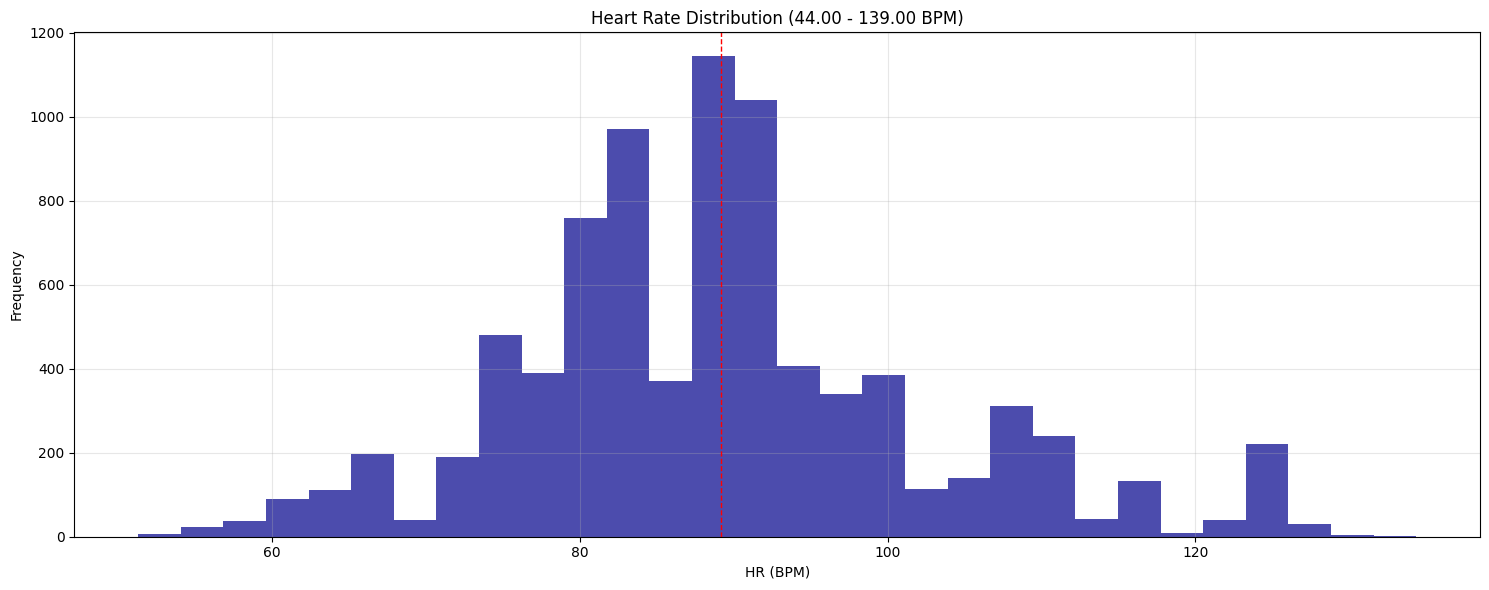

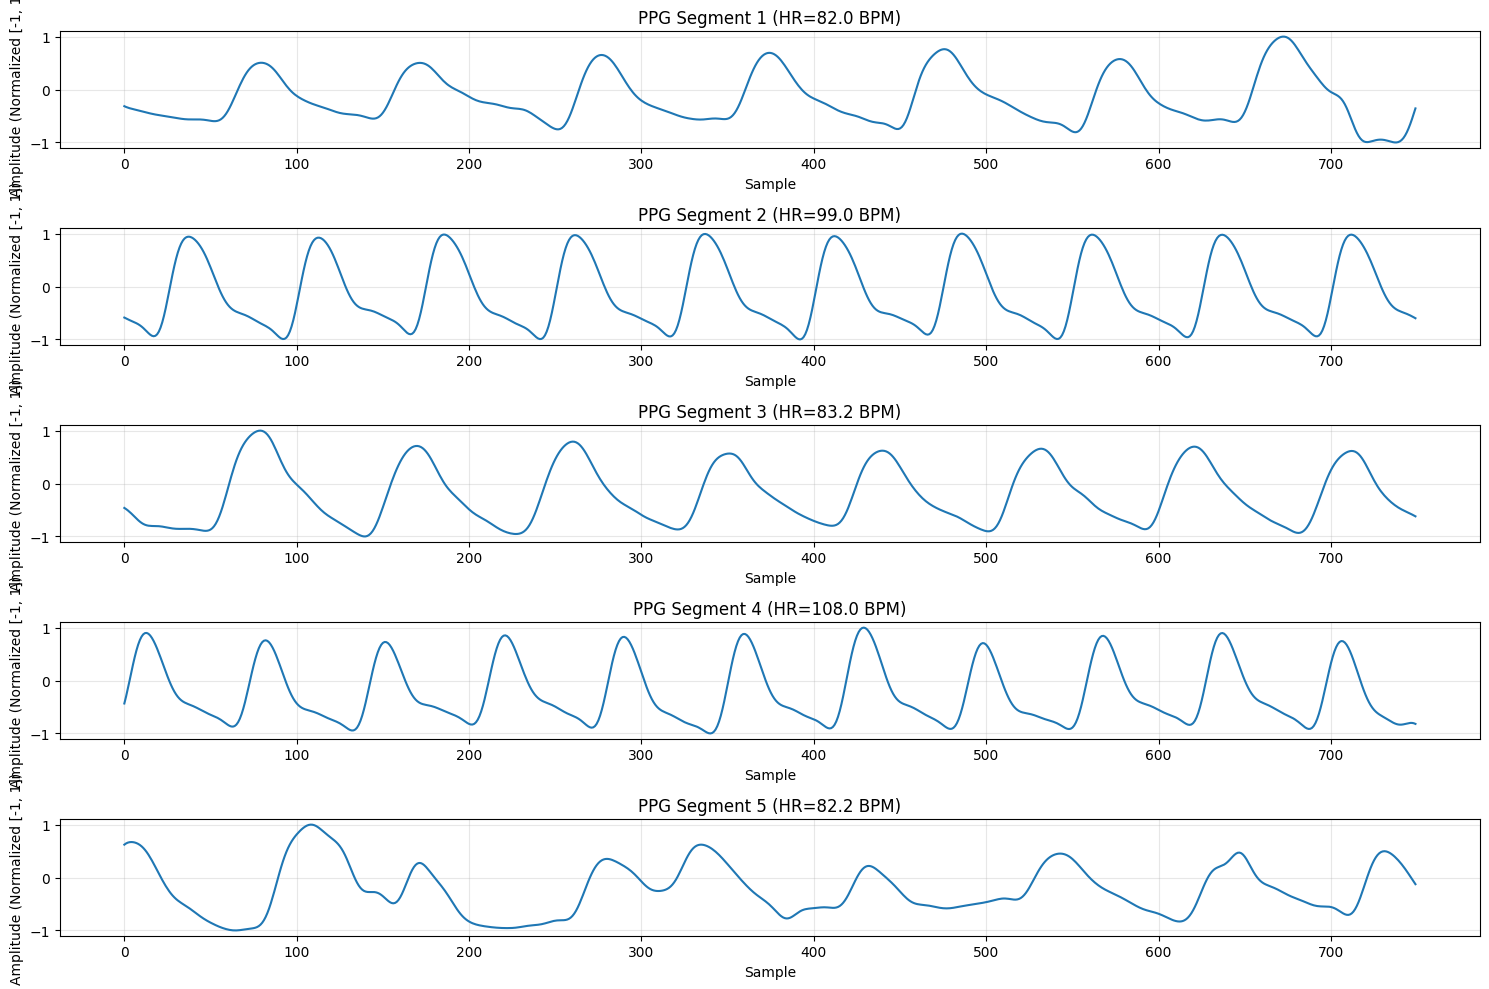


Tiền xử lý dữ liệu hoàn tất. Dữ liệu đã được lưu vào thư mục processed.


In [11]:
# Ghi thông tin tiền xử lý vào file
with open(os.path.join(processed_path, 'preprocessing_info.txt'), 'w', encoding='utf-8') as f:
    f.write("THONG TIN TIEN XU LY DU LIEU\n")
    f.write("============================\n\n")
    f.write(f"So ban ghi xu ly thanh cong: {valid_records}/{len(data)}\n")
    f.write(f"Tong so doan tin hieu: {len(ppg_segments)}\n\n")
    f.write("Tham so tien xu ly:\n")
    f.write(f"- Tan so lay mau: {fs} Hz\n")
    f.write(f"- Do dai doan tin hieu: {segment_length} mau ({segment_length/fs} giay)\n")
    f.write(f"- Do chong lap: {overlap*100}%\n\n")
    f.write("Kich thuoc du lieu:\n")
    f.write(f"- Tap huan luyen: {X_train.shape[0]} mau\n")
    f.write(f"- Tap kiem thu: {X_test.shape[0]} mau\n")
    f.write(f"- Toan bo du lieu: {X_total_norm.shape[0]} mau\n\n")
    f.write("Thong tin chuẩn hóa:\n")
    f.write(f"- PPG: Chuẩn hóa MinMax [-1, 1] cho từng đoạn\n")
    f.write(f"- HR: Giá trị thô (raw) trong phạm vi [{HR_MIN:.2f}, {HR_MAX:.2f}] BPM\n\n")
    f.write("Thong ke HR (raw):\n")
    f.write(f"- Min: {np.min(hr_raw_segments):.4f}, Max: {np.max(hr_raw_segments):.4f}\n")
    f.write(f"- Mean: {np.mean(hr_raw_segments):.4f}, Std: {np.std(hr_raw_segments):.4f}\n\n")
    if valid_records == 0:
        f.write("\nLuu y: Du lieu la gia lap do khong trich xuat duoc tu BIDMC.\n")
# Vẽ phân phối HR
plt.figure(figsize=(15, 6))
plt.hist(hr_raw_segments, bins=30, alpha=0.7, color='darkblue')
plt.axvline(np.mean(hr_raw_segments), color='red', linestyle='dashed', linewidth=1)
plt.title(f'Heart Rate Distribution ({HR_MIN:.2f} - {HR_MAX:.2f} BPM)')
plt.xlabel('HR (BPM)')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(os.path.join(figures_path, 'hr_distribution.png'))
plt.show()

# Vẽ một số đoạn PPG
plt.figure(figsize=(15, 10))
for i in range(min(5, len(X_train))):
    plt.subplot(5, 1, i+1)
    plt.plot(X_train[i])
    actual_hr = hr_raw_train[i]
    plt.title(f'PPG Segment {i+1} (HR={actual_hr:.1f} BPM)')
    plt.xlabel('Sample')
    plt.ylabel('Amplitude (Normalized [-1, 1])')
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(figures_path, 'preprocessed_ppg_segments.png'))
plt.show()

print("\nTiền xử lý dữ liệu hoàn tất. Dữ liệu đã được lưu vào thư mục processed.")

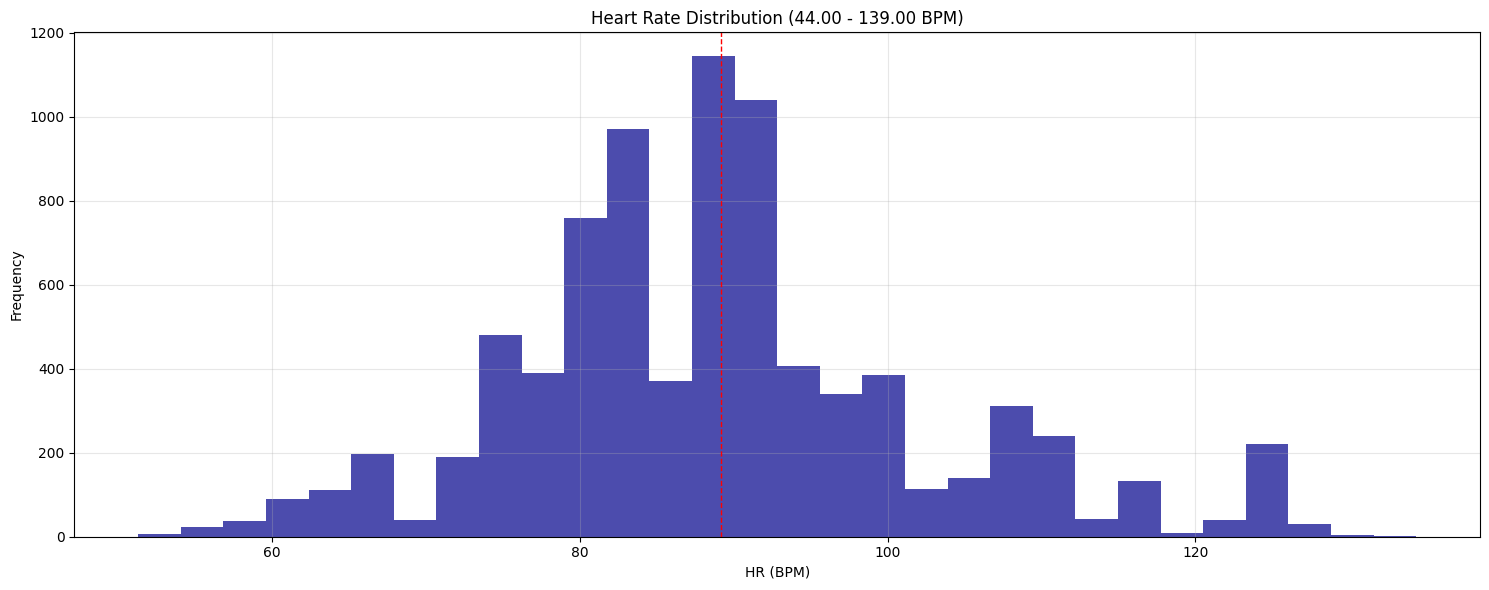

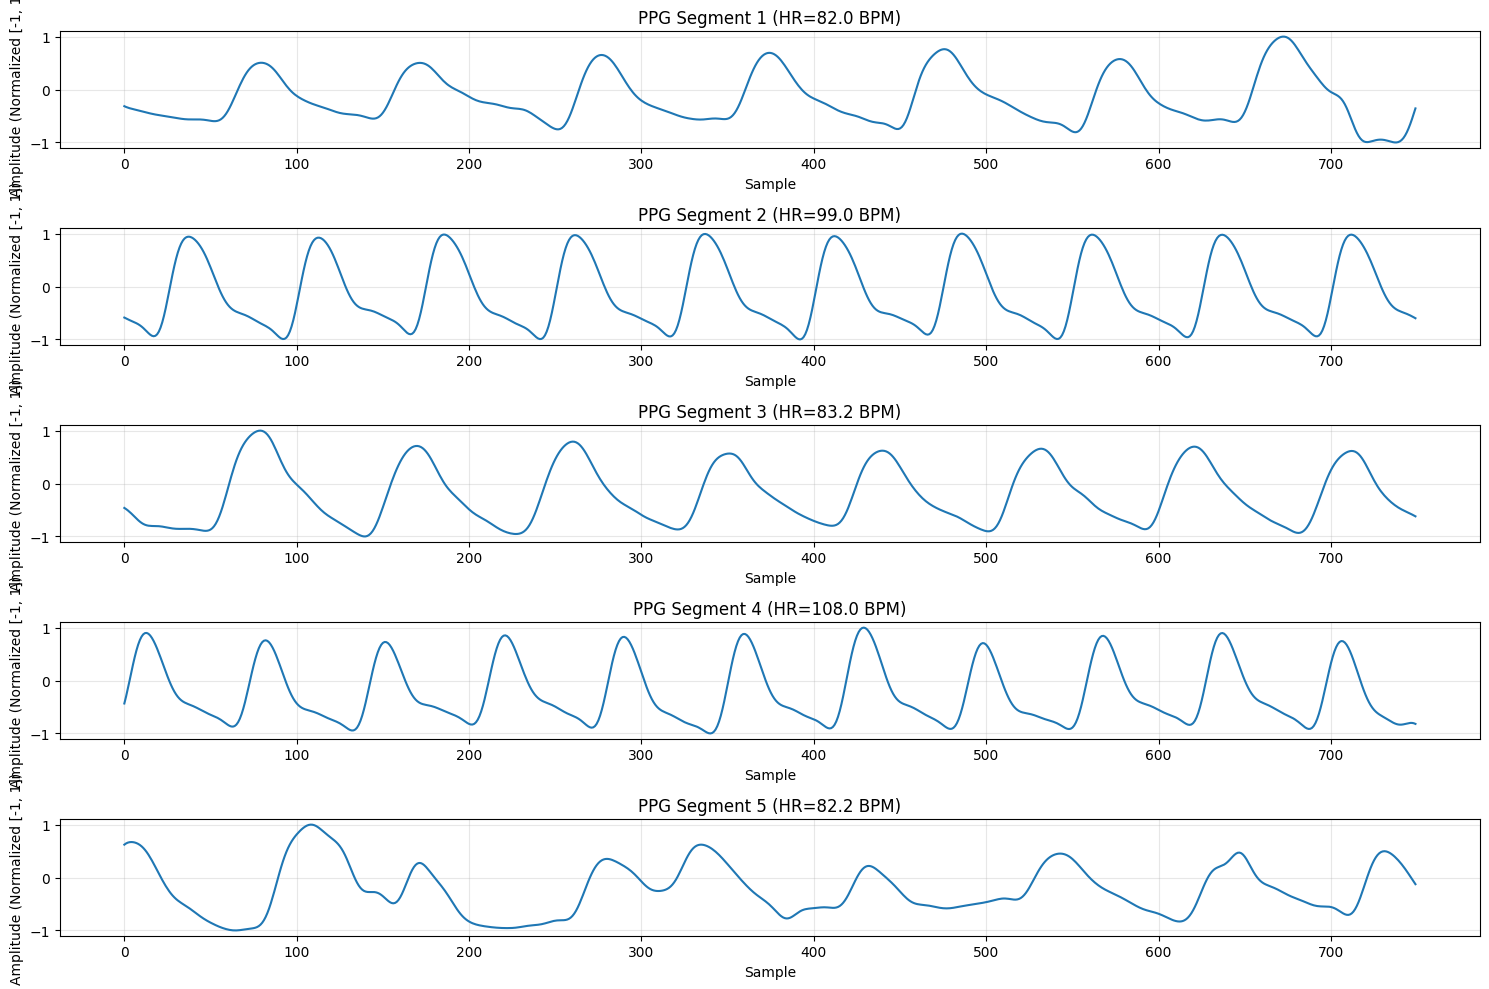


Tiền xử lý dữ liệu hoàn tất. Dữ liệu đã được lưu vào thư mục processed.


In [12]:
# Vẽ phân phối HR
plt.figure(figsize=(15, 6))
plt.hist(hr_raw_segments, bins=30, alpha=0.7, color='darkblue')
plt.axvline(np.mean(hr_raw_segments), color='red', linestyle='dashed', linewidth=1)
plt.title(f'Heart Rate Distribution ({HR_MIN:.2f} - {HR_MAX:.2f} BPM)')
plt.xlabel('HR (BPM)')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(os.path.join(figures_path, 'hr_distribution.png'))
plt.show()

# Vẽ một số đoạn PPG
plt.figure(figsize=(15, 10))
for i in range(min(5, len(X_train))):
    plt.subplot(5, 1, i+1)
    plt.plot(X_train[i])
    actual_hr = hr_raw_train[i]
    plt.title(f'PPG Segment {i+1} (HR={actual_hr:.1f} BPM)')
    plt.xlabel('Sample')
    plt.ylabel('Amplitude (Normalized [-1, 1])')
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(figures_path, 'preprocessed_ppg_segments.png'))
plt.show()

print("\nTiền xử lý dữ liệu hoàn tất. Dữ liệu đã được lưu vào thư mục processed.")

In [13]:
import torch
from torch.utils.data import Dataset, DataLoader

In [14]:
# Định nghĩa Dataset
class BIDMCDataset(Dataset):
    def __init__(self, signals):
        if not isinstance(signals, np.ndarray):
            signals = np.array(signals)
        self.signals = torch.tensor(signals, dtype=torch.float32)  # Tín hiệu PPG

    def __len__(self):
        return len(self.signals)

    def __getitem__(self, idx):
        return self.signals[idx]

# Tạo Dataset
train_dataset = BIDMCDataset(X_train_norm)
test_dataset = BIDMCDataset(X_test_norm)

batch_size = 64
# Tạo DataLoader
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Kiểm tra batch đầu tiên từ train_loader
sample_batch = next(iter(train_loader))
print(f"Sample batch type: {type(sample_batch)}")
print(f"Sample batch shape: {sample_batch.shape}")

Sample batch type: <class 'torch.Tensor'>
Sample batch shape: torch.Size([64, 750])


Keys trong file .mat: ['__header__', '__version__', '__globals__', 'X_train_norm', 'X_test_norm', 'hr_raw_train', 'hr_raw_test', 'X_total_norm', 'hr_raw_total']

Shape của các dữ liệu:
X_train_norm shape: (6614, 750)
X_test_norm shape: (1654, 750)
hr_raw_train shape: (6614,)
hr_raw_test shape: (1654,)
X_total_norm shape: (8268, 750)
hr_raw_total shape: (8268,)

Kiểm tra giá trị NaN và vô cùng:
Có giá trị NaN trong X_train_norm: False
Có giá trị vô cùng trong X_train_norm: False
Có giá trị NaN trong hr_raw_train: False
Có giá trị vô cùng trong hr_raw_train: False

Phạm vi giá trị:
Giá trị min của X_train_norm: -1.0
Giá trị max của X_train_norm: 1.0000000000000004
HR range: [51.33, 131.33] BPM


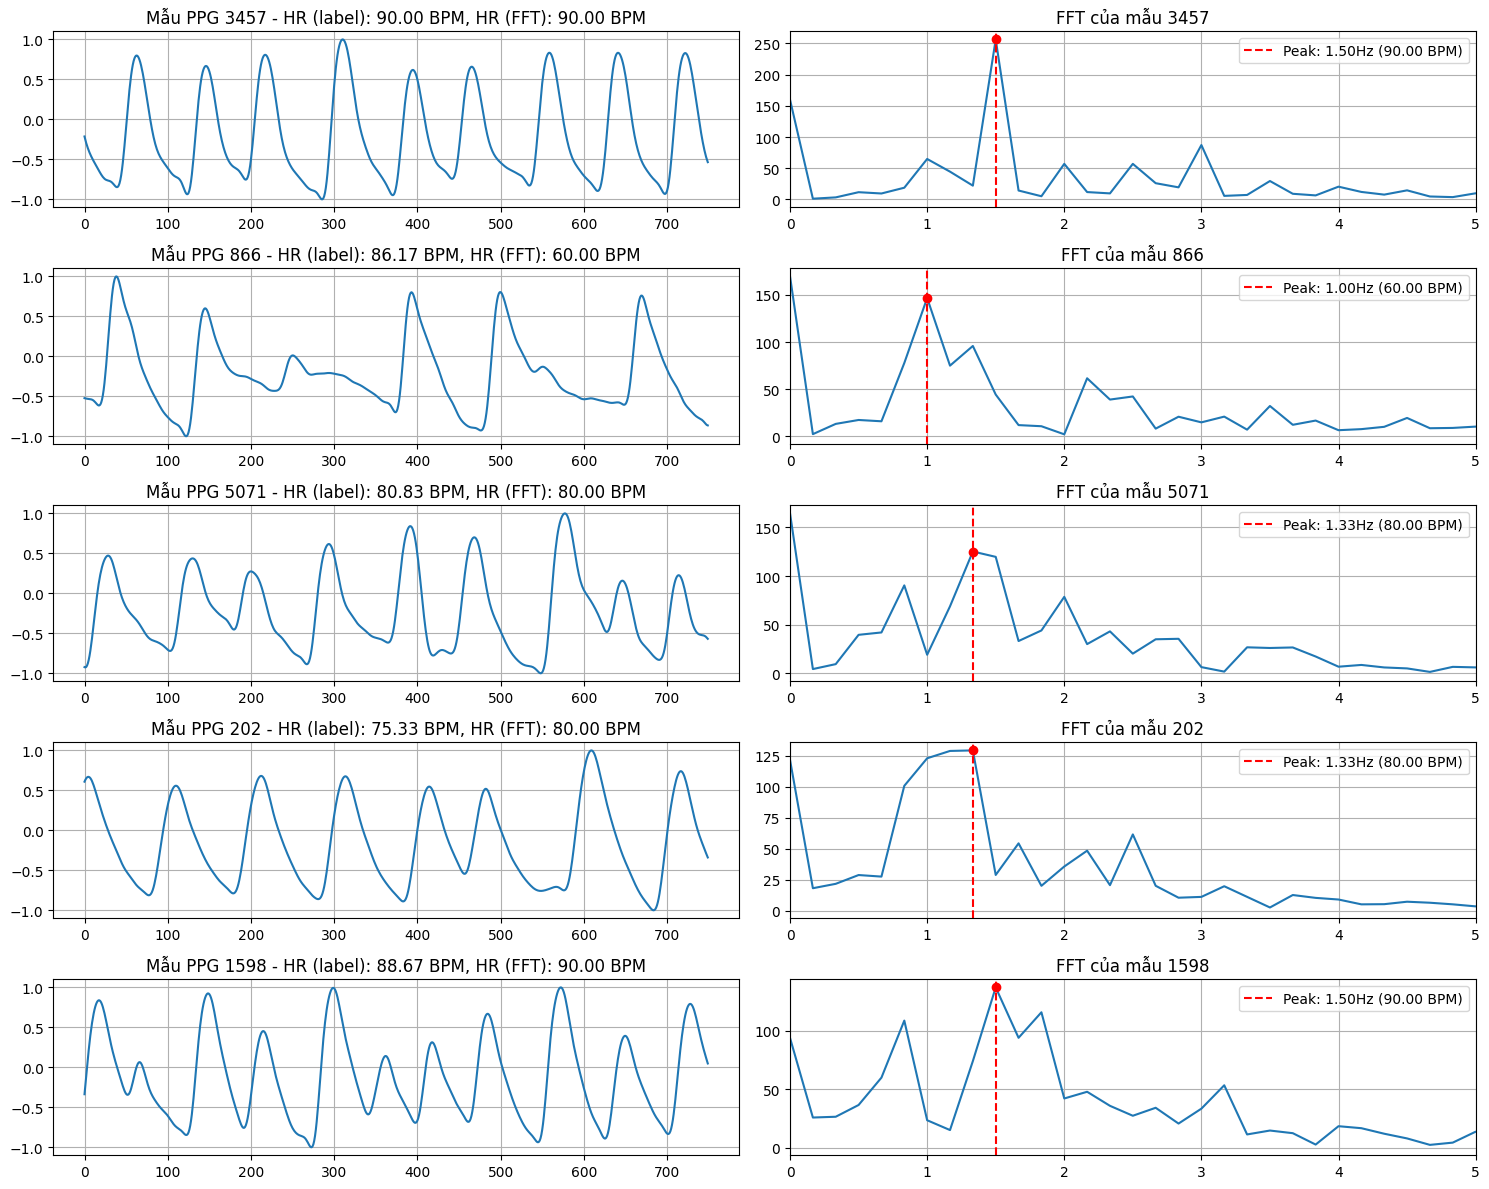


Kích thước batch dữ liệu: torch.Size([64, 750])


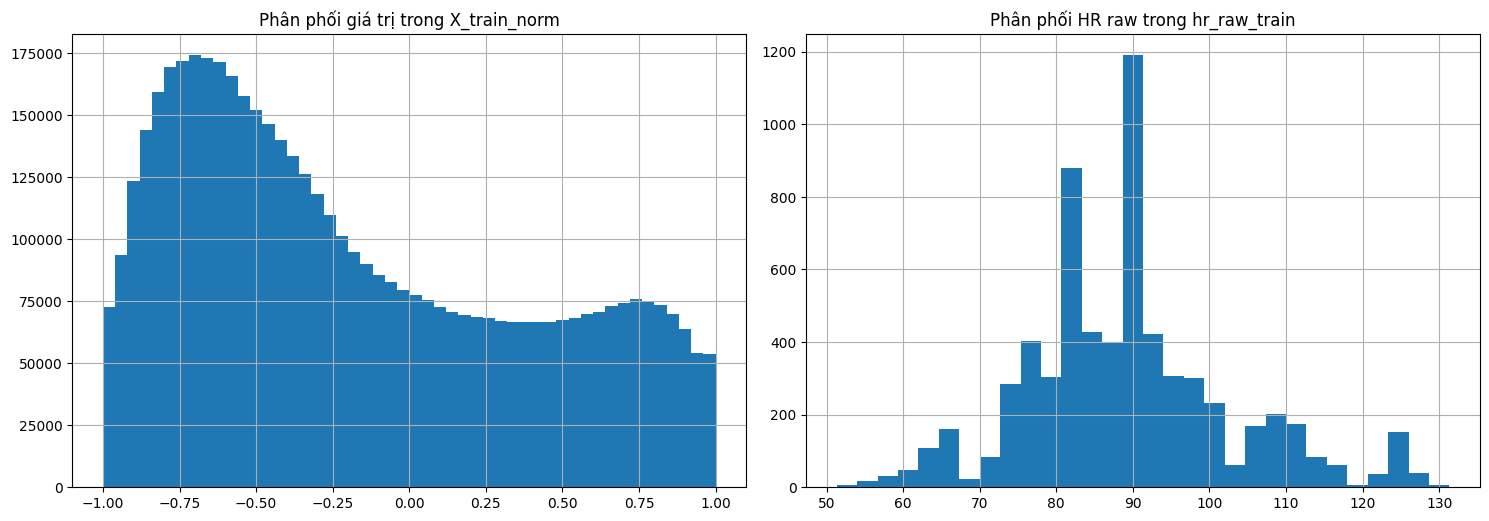

In [15]:
# Load data từ file .mat
import scipy.io as sio
data = sio.loadmat('processed_bidmc_data.mat')

# Kiểm tra các keys trong file
print("Keys trong file .mat:", list(data.keys()))

# Kiểm tra dữ liệu đã load
X_train_norm = data['X_train_norm']
X_test_norm = data['X_test_norm']
hr_raw_train = data['hr_raw_train'].flatten()
hr_raw_test = data['hr_raw_test'].flatten()
X_total_norm = data['X_total_norm']
hr_raw_total = data['hr_raw_total'].flatten()

# In ra shape của các dữ liệu
print("\nShape của các dữ liệu:")
print(f"X_train_norm shape: {X_train_norm.shape}")
print(f"X_test_norm shape: {X_test_norm.shape}")
print(f"hr_raw_train shape: {hr_raw_train.shape}")
print(f"hr_raw_test shape: {hr_raw_test.shape}")
print(f"X_total_norm shape: {X_total_norm.shape}")
print(f"hr_raw_total shape: {hr_raw_total.shape}")

# Kiểm tra giá trị NaN hoặc vô cùng
print("\nKiểm tra giá trị NaN và vô cùng:")
print(f"Có giá trị NaN trong X_train_norm: {np.isnan(X_train_norm).any()}")
print(f"Có giá trị vô cùng trong X_train_norm: {np.isinf(X_train_norm).any()}")
print(f"Có giá trị NaN trong hr_raw_train: {np.isnan(hr_raw_train).any()}")
print(f"Có giá trị vô cùng trong hr_raw_train: {np.isinf(hr_raw_train).any()}")

# Kiểm tra phạm vi giá trị
print("\nPhạm vi giá trị:")
print(f"Giá trị min của X_train_norm: {np.min(X_train_norm)}")
print(f"Giá trị max của X_train_norm: {np.max(X_train_norm)}")
print(f"HR range: [{np.min(hr_raw_train):.2f}, {np.max(hr_raw_train):.2f}] BPM")

# Định nghĩa hàm tính FFT và trích xuất HR từ FFT
def compute_fft(signal, fs=125):
    """Tính FFT của tín hiệu"""
    n = len(signal)
    fft_result = np.abs(np.fft.rfft(signal))
    freqs = np.fft.rfftfreq(n, d=1/fs)
    return freqs, fft_result

def extract_hr_from_fft(signal, fs=125):
    """Trích xuất nhịp tim từ FFT của tín hiệu PPG"""
    freqs, fft_result = compute_fft(signal, fs)

    # Lọc dải tần số liên quan đến nhịp tim (0.5Hz - 3.5Hz ~ 30-210 BPM)
    mask = (freqs >= 0.5) & (freqs <= 3.5)
    filtered_freqs = freqs[mask]
    filtered_fft = fft_result[mask]

    # Tìm đỉnh cao nhất trong dải tần số
    if len(filtered_freqs) > 0:
        peak_idx = np.argmax(filtered_fft)
        peak_freq = filtered_freqs[peak_idx]

        # Chuyển đổi từ Hz sang BPM
        hr_from_fft = peak_freq * 60
        return hr_from_fft, peak_freq, filtered_freqs, filtered_fft
    else:
        return None, None, filtered_freqs, filtered_fft

# Hiển thị một số mẫu dữ liệu
plt.figure(figsize=(15, 12))

# Hiển thị 5 mẫu PPG ngẫu nhiên từ tập train
num_samples = 5
random_indices = np.random.choice(len(X_train_norm), num_samples, replace=False)

for i, idx in enumerate(random_indices):
    plt.subplot(num_samples, 2, 2*i+1)
    plt.plot(X_train_norm[idx])

    # Trích xuất HR từ FFT
    hr_fft, peak_freq, filtered_freqs, filtered_fft = extract_hr_from_fft(X_train_norm[idx])
    hr_label = f"HR (label): {hr_raw_train[idx]:.2f} BPM"
    hr_fft_text = f"HR (FFT): {hr_fft:.2f} BPM" if hr_fft is not None else "HR (FFT): N/A"

    plt.title(f"Mẫu PPG {idx} - {hr_label}, {hr_fft_text}")
    plt.grid(True)

    # Hiển thị FFT của mẫu
    plt.subplot(num_samples, 2, 2*i+2)
    freqs, amplitude = compute_fft(X_train_norm[idx])
    plt.plot(freqs, amplitude)

    # Đánh dấu đỉnh FFT tương ứng với HR
    if peak_freq is not None:
        plt.axvline(x=peak_freq, color='r', linestyle='--',
                   label=f'Peak: {peak_freq:.2f}Hz ({hr_fft:.2f} BPM)')
        plt.plot(peak_freq, np.max(filtered_fft), 'ro')

    plt.xlim(0, 5)  # Giới hạn tần số hiển thị đến 5Hz
    plt.title(f"FFT của mẫu {idx}")
    plt.grid(True)
    plt.legend()

plt.tight_layout()
plt.show()

# Kiểm tra phân phối của dữ liệu
plt.figure(figsize=(15, 10))

# Phân phối giá trị trong X_train_norm
plt.subplot(2, 2, 1)
plt.hist(X_train_norm.flatten(), bins=50)
plt.title("Phân phối giá trị trong X_train_norm")
plt.grid(True)

# Phân phối HR trong hr_raw_train
plt.subplot(2, 2, 2)
plt.hist(hr_raw_train, bins=30)
plt.title("Phân phối HR raw trong hr_raw_train")
plt.grid(True)

# Kiểm tra batch từ DataLoader
sample_batch_data = next(iter(train_loader))
print(f"\nKích thước batch dữ liệu: {sample_batch_data.shape}")

plt.tight_layout()
plt.show()

# **MODEL**

In [16]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim.lr_scheduler import ReduceLROnPlateau
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.io import loadmat  # Thêm import loadmat từ scipy.io

In [17]:
# Load dữ liệu từ file .mat
print("Đang load dữ liệu từ file processed_bidmc_data.mat...")
loaded_data = loadmat('processed_bidmc_data.mat')

# Trích xuất dữ liệu
X_train_loaded = loaded_data['X_train_norm']
X_test_loaded = loaded_data['X_test_norm']
hr_raw_train_loaded = loaded_data['hr_raw_train'].flatten()  # Flatten để chuyển từ (1, n) thành (n,)
hr_raw_test_loaded = loaded_data['hr_raw_test'].flatten()    # Flatten để chuyển từ (1, n) thành (n,)
X_total_loaded = loaded_data['X_total_norm']
hr_raw_total_loaded = loaded_data['hr_raw_total'].flatten()  # Flatten để chuyển từ (1, n) thành (n,)

# Kiểm tra kích thước dữ liệu đã load
print("\nShape của dữ liệu đã load:")
print(f"X_train_loaded shape: {X_train_loaded.shape}")
print(f"hr_raw_train_loaded shape: {hr_raw_train_loaded.shape}")
print(f"X_test_loaded shape: {X_test_loaded.shape}")
print(f"hr_raw_test_loaded shape: {hr_raw_test_loaded.shape}")
print(f"X_total_loaded shape: {X_total_loaded.shape}")
print(f"hr_raw_total_loaded shape: {hr_raw_total_loaded.shape}")

# Tính toán thống kê cho hr_raw_total_loaded
hr_raw_total_min = np.min(hr_raw_total_loaded)
hr_raw_total_max = np.max(hr_raw_total_loaded)
hr_raw_total_mean = np.mean(hr_raw_total_loaded)
hr_raw_total_std = np.std(hr_raw_total_loaded)

# In thống kê
print("\nThống kê HR raw total:")
print(f"Min: {hr_raw_total_min:.2f}, Max: {hr_raw_total_max:.2f}")
print(f"Mean: {hr_raw_total_mean:.2f}, Std: {hr_raw_total_std:.2f}")
print(f"Mean ± Std: {hr_raw_total_mean:.2f} ± {hr_raw_total_std:.2f}")

Đang load dữ liệu từ file processed_bidmc_data.mat...

Shape của dữ liệu đã load:
X_train_loaded shape: (6614, 750)
hr_raw_train_loaded shape: (6614,)
X_test_loaded shape: (1654, 750)
hr_raw_test_loaded shape: (1654,)
X_total_loaded shape: (8268, 750)
hr_raw_total_loaded shape: (8268,)

Thống kê HR raw total:
Min: 51.33, Max: 134.33
Mean: 89.20, Std: 13.42
Mean ± Std: 89.20 ± 13.42


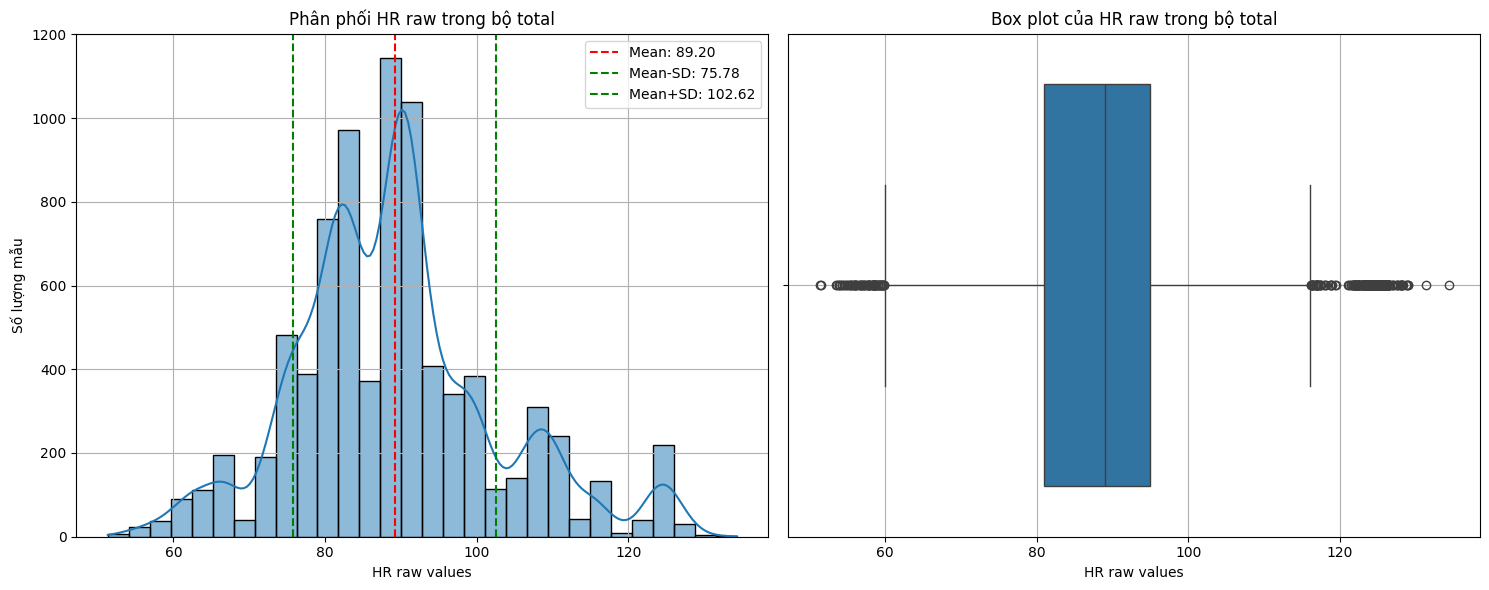

In [18]:
# Vẽ phân phối HR raw của bộ total
plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
sns.histplot(hr_raw_total_loaded, kde=True, bins=30)
plt.title('Phân phối HR raw trong bộ total')
plt.xlabel('HR raw values')
plt.ylabel('Số lượng mẫu')
plt.axvline(hr_raw_total_mean, color='r', linestyle='--', label=f'Mean: {hr_raw_total_mean:.2f}')
plt.axvline(hr_raw_total_mean - hr_raw_total_std, color='g', linestyle='--', label=f'Mean-SD: {hr_raw_total_mean - hr_raw_total_std:.2f}')
plt.axvline(hr_raw_total_mean + hr_raw_total_std, color='g', linestyle='--', label=f'Mean+SD: {hr_raw_total_mean + hr_raw_total_std:.2f}')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
sns.boxplot(x=hr_raw_total_loaded)
plt.title('Box plot của HR raw trong bộ total')
plt.xlabel('HR raw values')
plt.grid(True)

plt.tight_layout()
plt.show()

In [19]:
# Lọc dữ liệu nằm trong phạm vi mean ± 2*std của HR raw total
hr_raw_lower_bound = hr_raw_total_mean - 2 * hr_raw_total_std
hr_raw_upper_bound = hr_raw_total_mean + 2 * hr_raw_total_std

print(f"\nLọc dữ liệu trong khoảng HR raw: [{hr_raw_lower_bound:.2f}, {hr_raw_upper_bound:.2f}]")

# Tạo mask cho các mẫu nằm trong khoảng cho toàn bộ dữ liệu total
valid_mask_total = np.logical_and(
    hr_raw_total_loaded >= hr_raw_lower_bound,
    hr_raw_total_loaded <= hr_raw_upper_bound
)

# Lọc dữ liệu total
X_total_filtered = X_total_loaded[valid_mask_total]
hr_raw_total_filtered = hr_raw_total_loaded[valid_mask_total]

# Chuẩn hóa HR raw về khoảng [0, 1] dựa trên mean và std đã biết
hr_raw_mean = hr_raw_total_mean
hr_raw_std = hr_raw_total_std


Lọc dữ liệu trong khoảng HR raw: [62.37, 116.04]


In [20]:
# Hàm chuẩn hóa HR raw về khoảng [0, 1]
def normalize_hr_raw(hr_raw_data, mean=hr_raw_mean, std=hr_raw_std):
    # Sử dụng min-max normalization để scale về [0, 1]
    # Lấy giá trị min và max từ dữ liệu đã lọc
    hr_min = hr_raw_lower_bound  # Sử dụng giá trị biên dưới đã lọc
    hr_max = hr_raw_upper_bound  # Sử dụng giá trị biên trên đã lọc

    # Công thức chuẩn hóa min-max: (x - min) / (max - min)
    normalized = (hr_raw_data - hr_min) / (hr_max - hr_min)

    # Đảm bảo giá trị nằm trong khoảng [0, 1]
    normalized = np.clip(normalized, 0, 1)

    return normalized

# Áp dụng chuẩn hóa cho dữ liệu total đã lọc
hr_raw_total_normalized = normalize_hr_raw(hr_raw_total_filtered)


Thống kê HR raw total sau khi chuẩn hóa:
Min: 0.0025, Max: 0.9993
Mean: 0.4837, Std: 0.2049


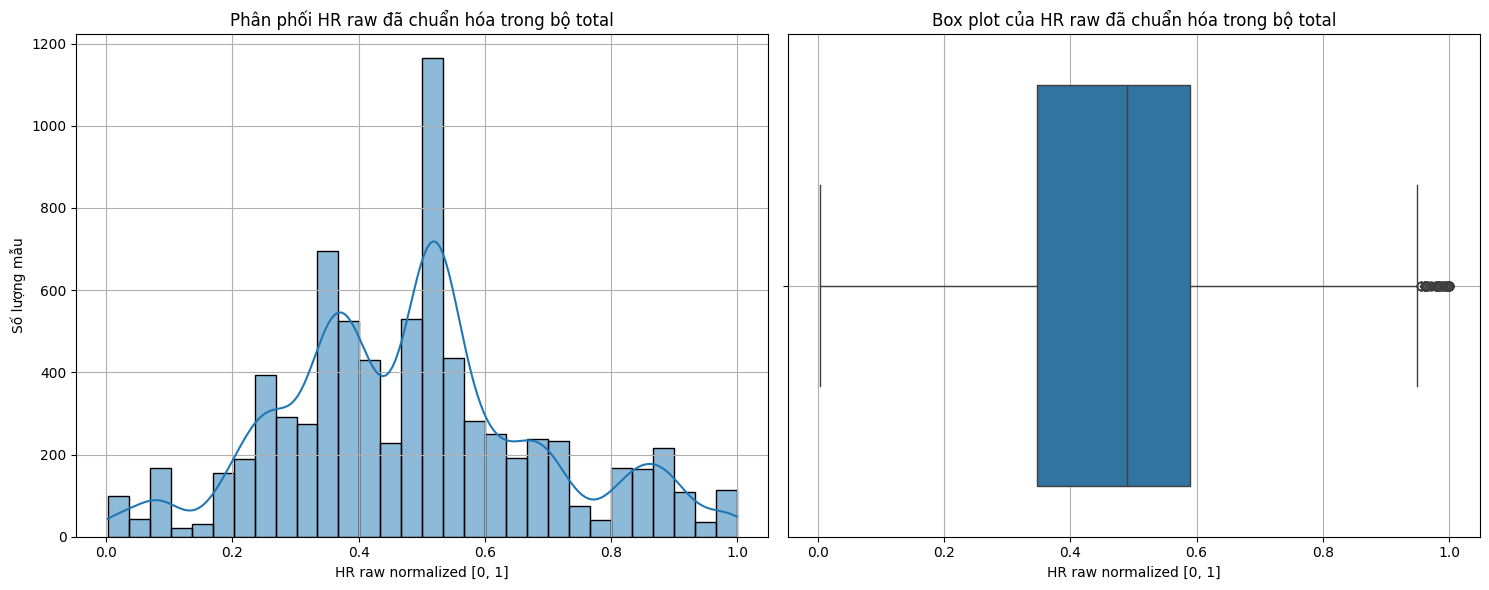

In [21]:
# Kiểm tra kết quả chuẩn hóa
print("\nThống kê HR raw total sau khi chuẩn hóa:")
print(f"Min: {np.min(hr_raw_total_normalized):.4f}, Max: {np.max(hr_raw_total_normalized):.4f}")
print(f"Mean: {np.mean(hr_raw_total_normalized):.4f}, Std: {np.std(hr_raw_total_normalized):.4f}")

# Vẽ phân phối HR raw sau khi chuẩn hóa
plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
sns.histplot(hr_raw_total_normalized, kde=True, bins=30)
plt.title('Phân phối HR raw đã chuẩn hóa trong bộ total')
plt.xlabel('HR raw normalized [0, 1]')
plt.ylabel('Số lượng mẫu')
plt.grid(True)

plt.subplot(1, 2, 2)
sns.boxplot(x=hr_raw_total_normalized)
plt.title('Box plot của HR raw đã chuẩn hóa trong bộ total')
plt.xlabel('HR raw normalized [0, 1]')
plt.grid(True)

plt.tight_layout()
plt.show()

In [22]:
# Chia lại thành tập train và test từ dữ liệu total đã lọc và chuẩn hóa
from sklearn.model_selection import train_test_split

# Sử dụng tỷ lệ 80% train, 20% test
X_train_filtered, X_test_filtered, hr_raw_train_normalized, hr_raw_test_normalized = train_test_split(
    X_total_filtered, hr_raw_total_normalized, test_size=0.2, random_state=42
)

# Lấy giá trị HR raw gốc tương ứng cho việc hiển thị - Sửa lỗi MemoryError
# Thay vì tạo bản sao mới, sử dụng lại indices từ lần split trước
train_indices = np.arange(len(X_total_filtered))
train_indices, test_indices = train_test_split(
    train_indices, test_size=0.2, random_state=42
)
hr_raw_train_filtered = hr_raw_total_filtered[train_indices]
hr_raw_test_filtered = hr_raw_total_filtered[test_indices]

Số mẫu train ban đầu: 6614
Số mẫu train sau khi lọc: 6224
Tỷ lệ giữ lại (train): 94.10%
Số mẫu test ban đầu: 1654
Số mẫu test sau khi lọc: 1557
Tỷ lệ giữ lại (test): 94.14%

Thống kê HR raw sau khi chia tập:
Train - Min: 0.0025, Max: 0.9993
Train - Mean: 0.4837, Std: 0.2048
Test - Min: 0.0025, Max: 0.9993
Test - Mean: 0.4838, Std: 0.2055


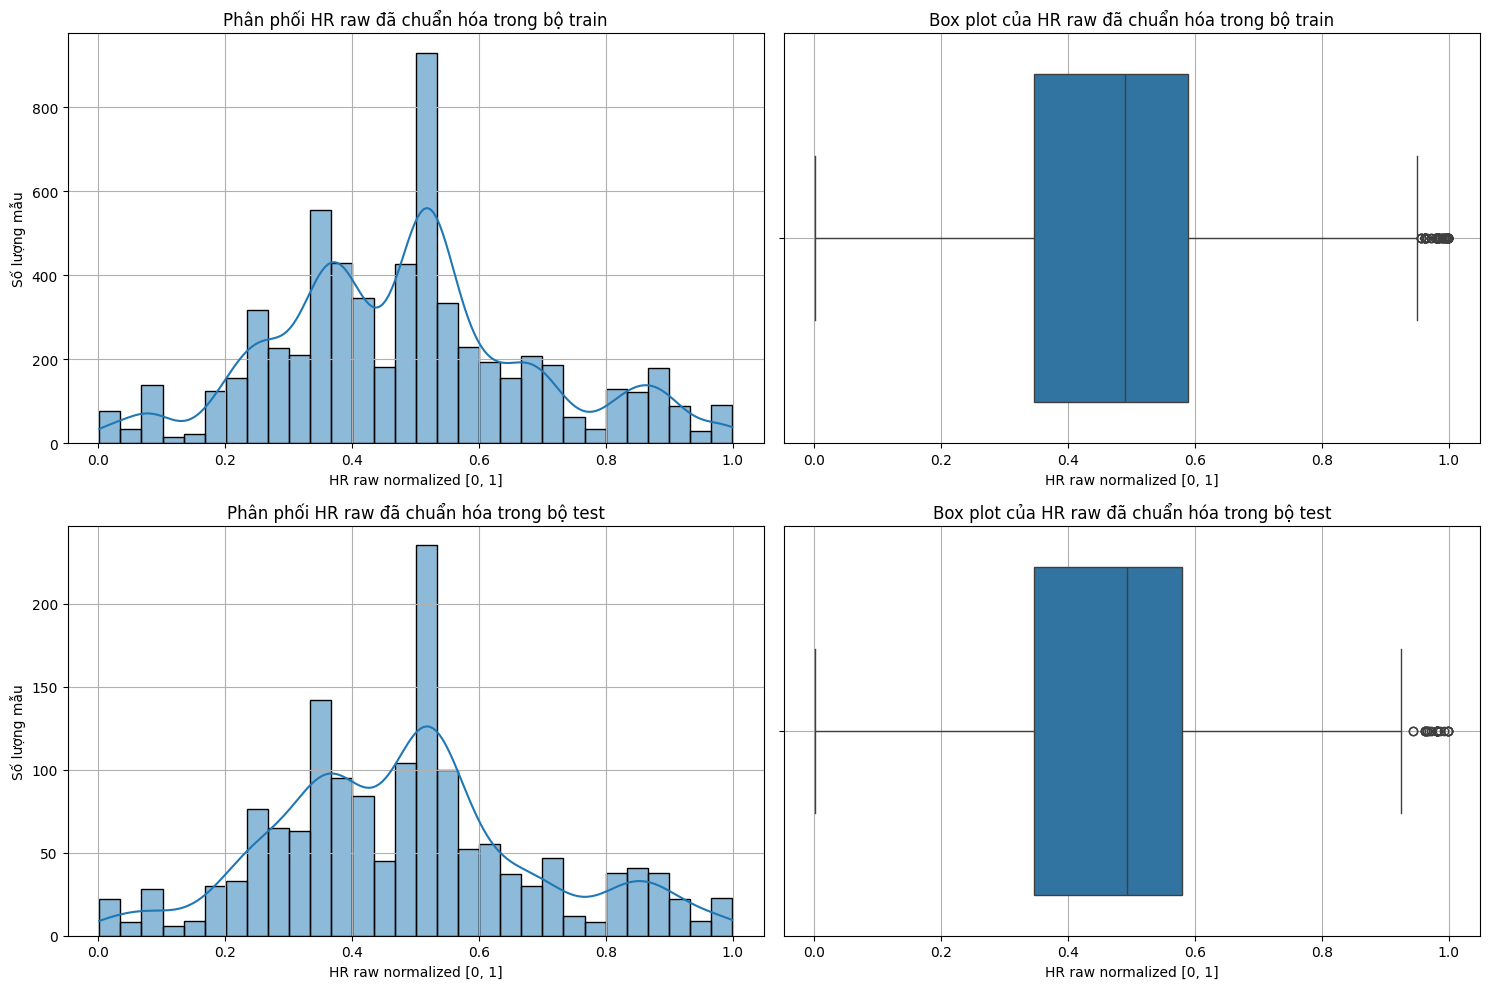

In [23]:
# In thông tin về số lượng mẫu đã lọc
print(f"Số mẫu train ban đầu: {X_train_loaded.shape[0]}")
print(f"Số mẫu train sau khi lọc: {X_train_filtered.shape[0]}")
print(f"Tỷ lệ giữ lại (train): {X_train_filtered.shape[0]/X_train_loaded.shape[0]*100:.2f}%")

print(f"Số mẫu test ban đầu: {X_test_loaded.shape[0]}")
print(f"Số mẫu test sau khi lọc: {X_test_filtered.shape[0]}")
print(f"Tỷ lệ giữ lại (test): {X_test_filtered.shape[0]/X_test_loaded.shape[0]*100:.2f}%")

# Kiểm tra thống kê HR raw sau khi chia tập
print("\nThống kê HR raw sau khi chia tập:")
print(f"Train - Min: {np.min(hr_raw_train_normalized):.4f}, Max: {np.max(hr_raw_train_normalized):.4f}")
print(f"Train - Mean: {np.mean(hr_raw_train_normalized):.4f}, Std: {np.std(hr_raw_train_normalized):.4f}")
print(f"Test - Min: {np.min(hr_raw_test_normalized):.4f}, Max: {np.max(hr_raw_test_normalized):.4f}")
print(f"Test - Mean: {np.mean(hr_raw_test_normalized):.4f}, Std: {np.std(hr_raw_test_normalized):.4f}")

# Vẽ phân phối HR raw sau khi chia tập
plt.figure(figsize=(15, 10))
plt.subplot(2, 2, 1)
sns.histplot(hr_raw_train_normalized, kde=True, bins=30)
plt.title('Phân phối HR raw đã chuẩn hóa trong bộ train')
plt.xlabel('HR raw normalized [0, 1]')
plt.ylabel('Số lượng mẫu')
plt.grid(True)

plt.subplot(2, 2, 2)
sns.boxplot(x=hr_raw_train_normalized)
plt.title('Box plot của HR raw đã chuẩn hóa trong bộ train')
plt.xlabel('HR raw normalized [0, 1]')
plt.grid(True)

plt.subplot(2, 2, 3)
sns.histplot(hr_raw_test_normalized, kde=True, bins=30)
plt.title('Phân phối HR raw đã chuẩn hóa trong bộ test')
plt.xlabel('HR raw normalized [0, 1]')
plt.ylabel('Số lượng mẫu')
plt.grid(True)

plt.subplot(2, 2, 4)
sns.boxplot(x=hr_raw_test_normalized)
plt.title('Box plot của HR raw đã chuẩn hóa trong bộ test')
plt.xlabel('HR raw normalized [0, 1]')
plt.grid(True)

plt.tight_layout()
plt.show()

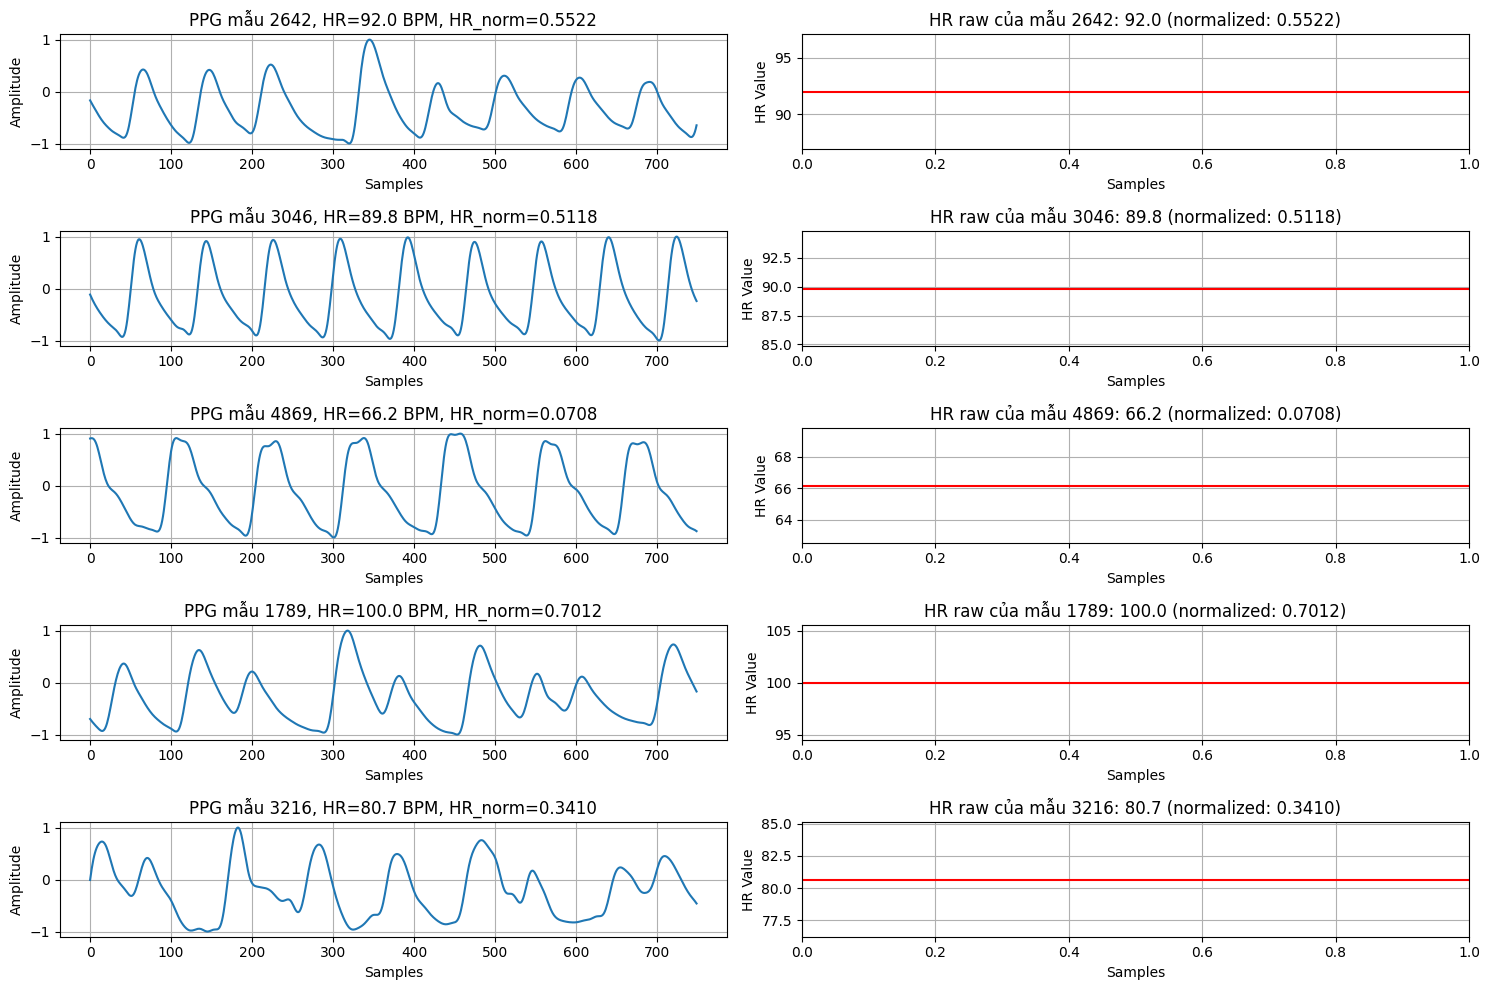

In [24]:
# Vẽ một vài mẫu để double check
plt.figure(figsize=(15, 10))
for i in range(5):
    idx = np.random.randint(0, X_train_filtered.shape[0])

    # Vẽ tín hiệu PPG
    plt.subplot(5, 2, i*2+1)
    plt.plot(X_train_filtered[idx])
    plt.title(f'PPG mẫu {idx}, HR={hr_raw_train_filtered[idx]:.1f} BPM, HR_norm={hr_raw_train_normalized[idx]:.4f}')
    plt.xlabel('Samples')
    plt.ylabel('Amplitude')
    plt.grid(True)

    # Vẽ tín hiệu HR raw tương ứng
    plt.subplot(5, 2, i*2+2)
    plt.axhline(hr_raw_train_filtered[idx], color='r')
    plt.title(f'HR raw của mẫu {idx}: {hr_raw_train_filtered[idx]:.1f} (normalized: {hr_raw_train_normalized[idx]:.4f})')
    plt.xlabel('Samples')
    plt.ylabel('HR Value')
    plt.grid(True)

plt.tight_layout()
plt.show()

In [25]:
# Thiết lập device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Sử dụng device: {device}")

# Giả sử dữ liệu đã được tiền xử lý như trong mã gốc
# Các biến như X_train_filtered, X_test_filtered, hr_raw_train_normalized, hr_raw_test_normalized đã được chuẩn bị
# Chuyển đổi dữ liệu thành tensor (không cần condition)
X_train_tensor = torch.FloatTensor(X_train_filtered)
X_test_tensor = torch.FloatTensor(X_test_filtered)

# Tạo dataset và dataloader (không cần condition)
train_dataset = TensorDataset(X_train_tensor)
test_dataset = TensorDataset(X_test_tensor)

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Thiết lập các tham số cho mô hình
input_size = X_train_filtered.shape[1]  # Kích thước của tín hiệu PPG
latent_dim = 64  # Kích thước không gian tiềm ẩn
hidden_dims = [256, 128, 64]  # Kích thước các lớp ẩn


Sử dụng device: cuda


In [26]:
# Định nghĩa lớp Sampling
class Sampling(nn.Module):
    def __init__(self):
        super(Sampling, self).__init__()

    def forward(self, args):
        z_mean, z_log_var = args
        batch_size = z_mean.size(0)
        latent_dim = z_mean.size(1)
        epsilon = torch.randn(batch_size, latent_dim).to(z_mean.device)
        return z_mean + torch.exp(0.5 * z_log_var) * epsilon

In [27]:
# Xây dựng Encoder
class Encoder(nn.Module):
    def __init__(self, input_dim, latent_dim, hidden_dims=[256, 128, 64]):
        super(Encoder, self).__init__()
        self.input_layer = nn.Linear(input_dim, hidden_dims[0])
        self.hidden_layers = nn.ModuleList()
        for i in range(len(hidden_dims) - 1):
            self.hidden_layers.append(nn.Linear(hidden_dims[i], hidden_dims[i+1]))
        self.z_mean = nn.Linear(hidden_dims[-1], latent_dim)
        self.z_log_var = nn.Linear(hidden_dims[-1], latent_dim)
        self.sampling = Sampling()

    def forward(self, x):
        x = F.relu(self.input_layer(x))
        for layer in self.hidden_layers:
            x = F.relu(layer(x))
        z_mean = self.z_mean(x)
        z_log_var = self.z_log_var(x)
        z = self.sampling((z_mean, z_log_var))
        return z_mean, z_log_var, z

In [28]:
# Xây dựng Decoder
class Decoder(nn.Module):
    def __init__(self, latent_dim, output_dim, hidden_dims=[64, 128, 256]):
        super(Decoder, self).__init__()
        self.input_layer = nn.Linear(latent_dim, hidden_dims[0])
        self.hidden_layers = nn.ModuleList()
        for i in range(len(hidden_dims) - 1):
            self.hidden_layers.append(nn.Linear(hidden_dims[i], hidden_dims[i+1]))
        self.output_layer = nn.Linear(hidden_dims[-1], output_dim)

    def forward(self, z):
        x = F.relu(self.input_layer(z))
        for layer in self.hidden_layers:
            x = F.relu(layer(x))
        x = torch.tanh(self.output_layer(x))
        return x

In [29]:
# Xây dựng VAE
class VAE(nn.Module):
    def __init__(self, encoder, decoder):
        super(VAE, self).__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, x):
        z_mean, z_log_var, z = self.encoder(x)
        reconstruction = self.decoder(z)
        return reconstruction, z_mean, z_log_var

    def generate(self, z=None, batch_size=1):
        if z is None:
            z = torch.randn(batch_size, self.encoder.z_mean.out_features).to(device)
        return self.decoder(z)

In [30]:
# Khởi tạo mô hình
encoder = Encoder(input_size, latent_dim, hidden_dims)
decoder = Decoder(latent_dim, input_size, hidden_dims[::-1])
vae = VAE(encoder, decoder)

# Chuyển mô hình sang device
vae.to(device)

# Hiển thị cấu trúc mô hình
print("\n=== Cấu trúc Encoder ===")
print(encoder)
print("\n=== Cấu trúc Decoder ===")
print(decoder)
print("\n=== Cấu trúc VAE ===")
print(vae)

# Tính tổng số tham số của mô hình
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"\nTổng số tham số của Encoder: {count_parameters(encoder):,}")
print(f"Tổng số tham số của Decoder: {count_parameters(decoder):,}")
print(f"Tổng số tham số của VAE: {count_parameters(vae):,}")


=== Cấu trúc Encoder ===
Encoder(
  (input_layer): Linear(in_features=750, out_features=256, bias=True)
  (hidden_layers): ModuleList(
    (0): Linear(in_features=256, out_features=128, bias=True)
    (1): Linear(in_features=128, out_features=64, bias=True)
  )
  (z_mean): Linear(in_features=64, out_features=64, bias=True)
  (z_log_var): Linear(in_features=64, out_features=64, bias=True)
  (sampling): Sampling()
)

=== Cấu trúc Decoder ===
Decoder(
  (input_layer): Linear(in_features=64, out_features=64, bias=True)
  (hidden_layers): ModuleList(
    (0): Linear(in_features=64, out_features=128, bias=True)
    (1): Linear(in_features=128, out_features=256, bias=True)
  )
  (output_layer): Linear(in_features=256, out_features=750, bias=True)
)

=== Cấu trúc VAE ===
VAE(
  (encoder): Encoder(
    (input_layer): Linear(in_features=750, out_features=256, bias=True)
    (hidden_layers): ModuleList(
      (0): Linear(in_features=256, out_features=128, bias=True)
      (1): Linear(in_features

In [31]:
# Định nghĩa hàm loss
def loss_function(x, x_recon, z_mean, z_log_var, kl_weight=0.5):
    recon_loss = F.mse_loss(x_recon, x, reduction='mean')
    kl_loss = -0.5 * torch.mean(1 + z_log_var - z_mean.pow(2) - z_log_var.exp())
    loss = recon_loss + kl_weight * kl_loss
    return loss, recon_loss, kl_loss

# Định nghĩa các tham số huấn luyện
learning_rate = 1e-3
epochs = 600

# Khởi tạo optimizer và scheduler
optimizer = torch.optim.Adam(vae.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=20, verbose=True)

# Khởi tạo danh sách để lưu lịch sử huấn luyện
train_losses = []
test_losses = []
recon_losses = []
kl_losses = []
best_loss = float('inf')

# Tham số cho early stopping
patience = 50
patience_counter = 0

# Tạo thư mục để lưu checkpoint
checkpoint_dir = 'checkpoints'
os.makedirs(checkpoint_dir, exist_ok=True)

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [32]:
# Vòng lặp huấn luyện
for epoch in range(epochs):
    vae.train()
    total_train_loss = 0
    total_train_recon_loss = 0
    total_train_kl_loss = 0

    for batch_idx, (data,) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        x_recon, z_mean, z_log_var = vae(data)
        loss, recon_loss, kl_loss = loss_function(data, x_recon, z_mean, z_log_var)
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item() * data.size(0)
        total_train_recon_loss += recon_loss.item() * data.size(0)
        total_train_kl_loss += kl_loss.item() * data.size(0)

    vae.eval()
    total_test_loss = 0
    total_test_recon_loss = 0
    total_test_kl_loss = 0

    with torch.no_grad():
        for data, in test_loader:
            data = data.to(device)
            x_recon, z_mean, z_log_var = vae(data)
            loss, recon_loss, kl_loss = loss_function(data, x_recon, z_mean, z_log_var)
            total_test_loss += loss.item() * data.size(0)
            total_test_recon_loss += recon_loss.item() * data.size(0)
            total_test_kl_loss += kl_loss.item() * data.size(0)

    train_loss = total_train_loss / len(train_loader.dataset)
    test_loss = total_test_loss / len(test_loader.dataset)
    train_recon_loss = total_train_recon_loss / len(train_loader.dataset)
    test_recon_loss = total_test_recon_loss / len(test_loader.dataset)
    train_kl_loss = total_train_kl_loss / len(train_loader.dataset)
    test_kl_loss = total_test_kl_loss / len(test_loader.dataset)

    scheduler.step(test_loss)
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    recon_losses.append(test_recon_loss)
    kl_losses.append(test_kl_loss)

    if epoch % 10 == 0:
        print(f"Epoch {epoch}/{epochs}")
        print(f"Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}")
        print(f"Recon Loss: {test_recon_loss:.4f}, KL Loss: {test_kl_loss:.4f}")

    if epoch % 50 == 0:
        checkpoint_path = os.path.join(checkpoint_dir, f'vae_checkpoint_epoch_{epoch}.pth')
        torch.save({
            'epoch': epoch,
            'model_state_dict': vae.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'train_loss': train_loss,
            'test_loss': test_loss,
            'train_losses': train_losses,
            'test_losses': test_losses,
            'recon_losses': recon_losses,
            'kl_losses': kl_losses
        }, checkpoint_path)

    if test_loss < best_loss:
        best_loss = test_loss
        best_model_path = 'best_vae_combined.pth'
        torch.save({
            'epoch': epoch,
            'model_state_dict': vae.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_loss': train_loss,
            'test_loss': test_loss
        }, best_model_path)
        patience_counter = 0
    else:
        patience_counter += 1

    if patience_counter >= patience:
        print(f"Early stopping tại epoch {epoch} vì không có cải thiện sau {patience} epochs")
        break

# Lưu lịch sử huấn luyện
history = {
    'train_losses': train_losses,
    'test_losses': test_losses,
    'recon_losses': recon_losses,
    'kl_losses': kl_losses
}
torch.save(history, 'training_history_vae.pth')

print("Huấn luyện hoàn tất!")

Epoch 0/600
Train Loss: 0.3142, Test Loss: 0.3132
Recon Loss: 0.3095, KL Loss: 0.0073
Epoch 10/600
Train Loss: 0.2119, Test Loss: 0.2070
Recon Loss: 0.1636, KL Loss: 0.0868
Epoch 20/600
Train Loss: 0.1501, Test Loss: 0.1511
Recon Loss: 0.1016, KL Loss: 0.0990
Epoch 30/600
Train Loss: 0.1382, Test Loss: 0.1407
Recon Loss: 0.0896, KL Loss: 0.1022
Epoch 40/600
Train Loss: 0.1310, Test Loss: 0.1384
Recon Loss: 0.0852, KL Loss: 0.1065
Epoch 50/600
Train Loss: 0.1282, Test Loss: 0.1319
Recon Loss: 0.0774, KL Loss: 0.1090
Epoch 60/600
Train Loss: 0.1261, Test Loss: 0.1313
Recon Loss: 0.0772, KL Loss: 0.1080
Epoch 70/600
Train Loss: 0.1245, Test Loss: 0.1300
Recon Loss: 0.0754, KL Loss: 0.1091
Epoch 80/600
Train Loss: 0.1228, Test Loss: 0.1292
Recon Loss: 0.0756, KL Loss: 0.1073
Epoch 90/600
Train Loss: 0.1220, Test Loss: 0.1275
Recon Loss: 0.0729, KL Loss: 0.1092
Epoch 100/600
Train Loss: 0.1213, Test Loss: 0.1289
Recon Loss: 0.0753, KL Loss: 0.1072
Epoch 110/600
Train Loss: 0.1210, Test Loss

# **Đánh giá mô hình**

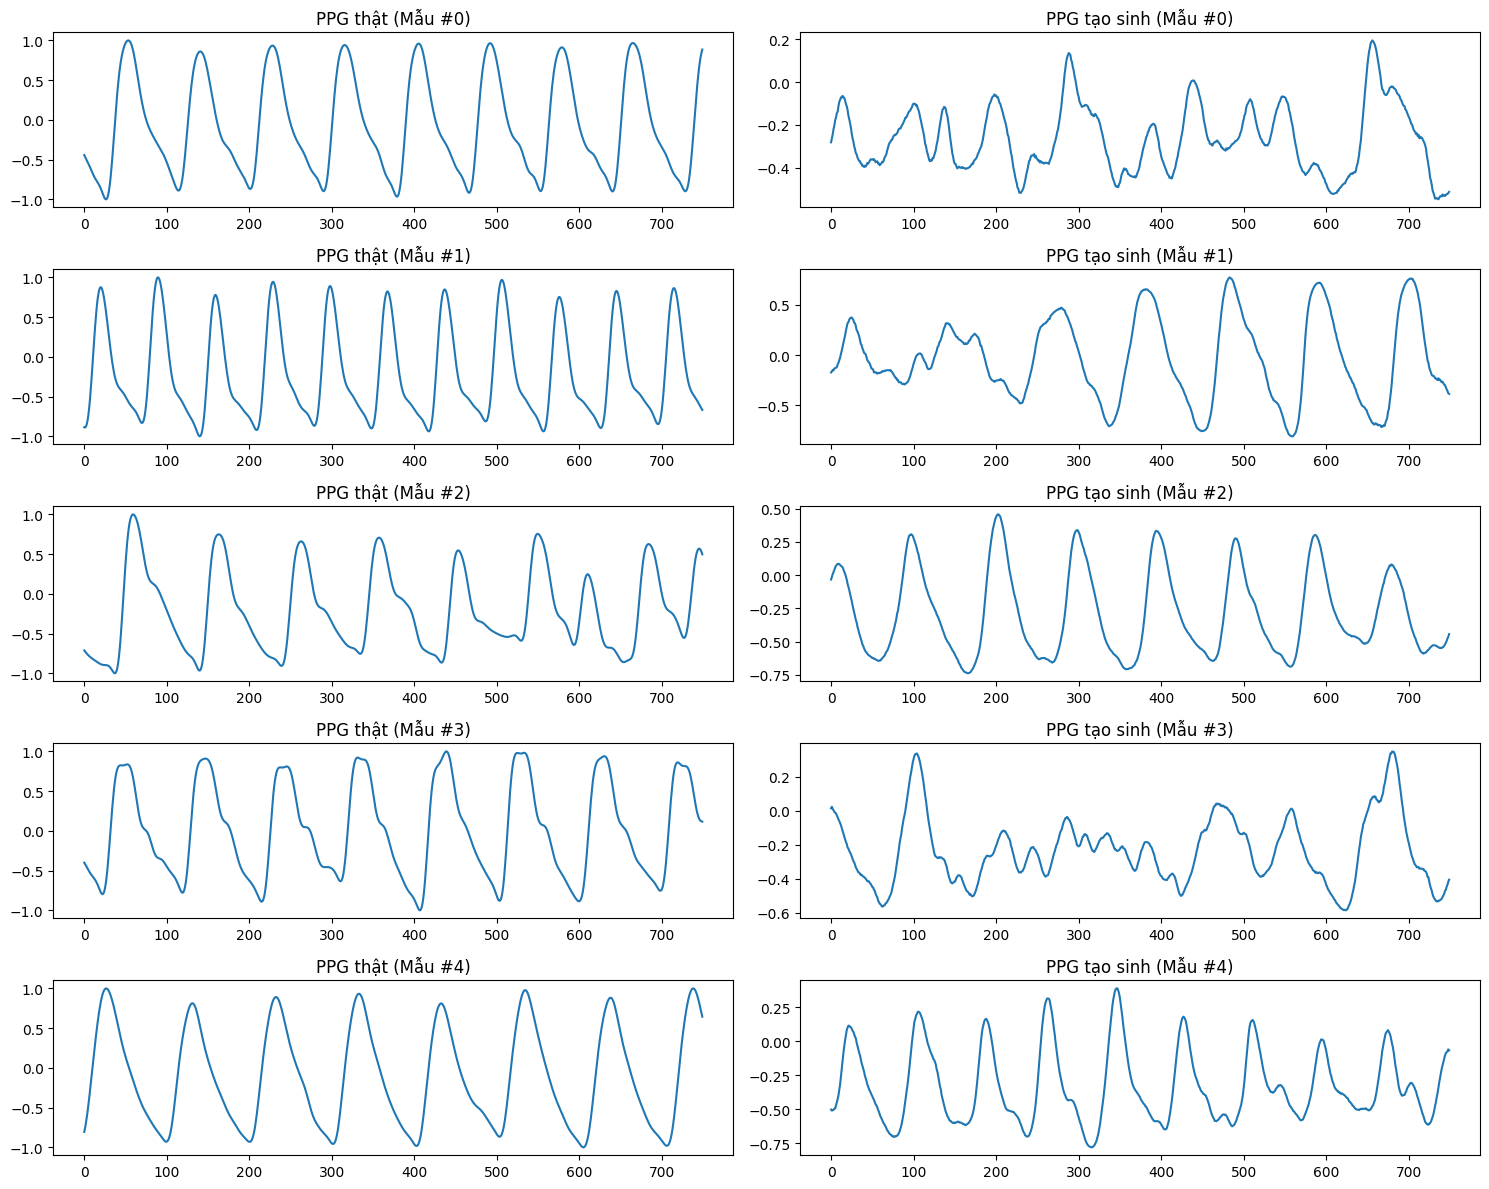

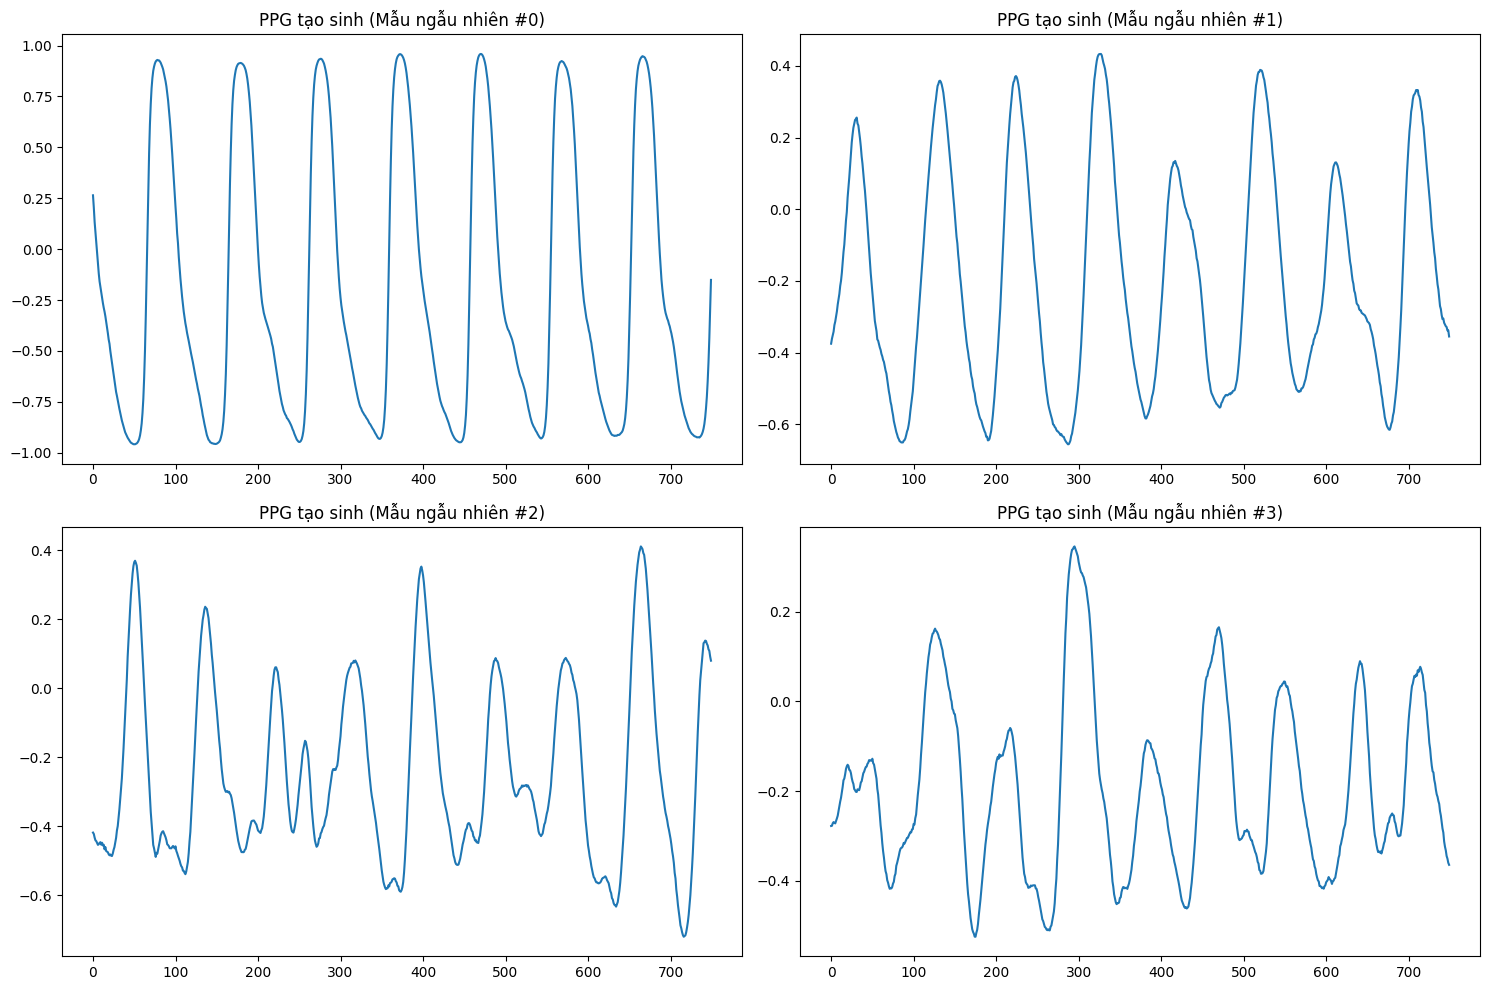

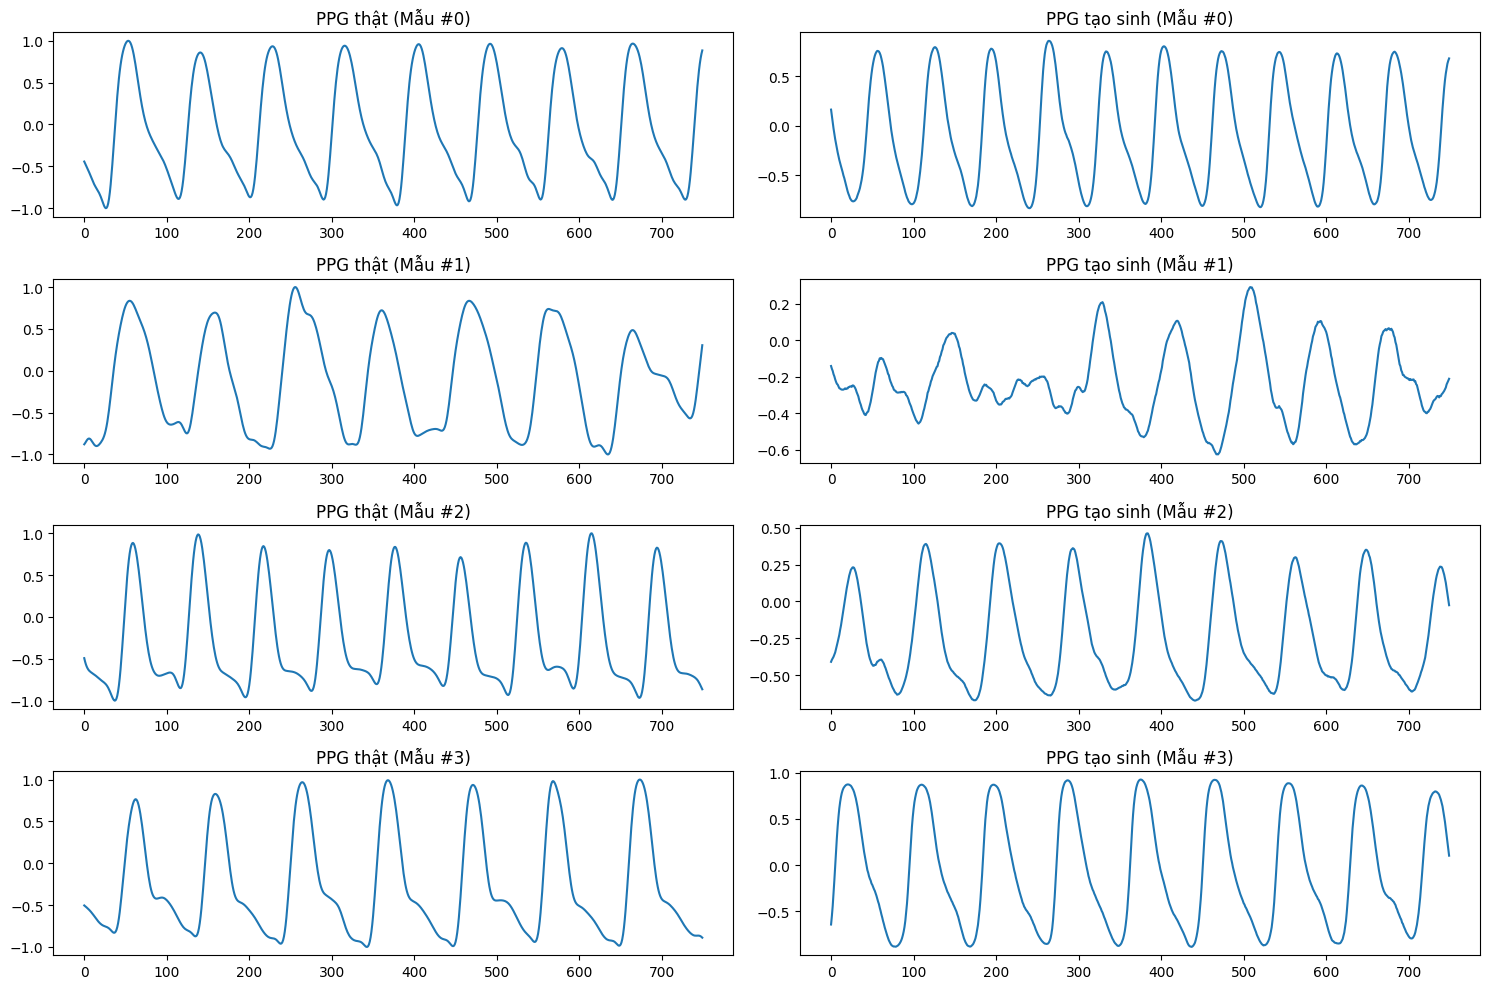

In [33]:
# Hàm đánh giá và tạo sinh PPG
def evaluate_generation(vae, device):
    """
    Tạo sinh PPG ngẫu nhiên

    Args:
        vae: mô hình VAE đã huấn luyện
        device: thiết bị tính toán (CPU/GPU)

    Returns:
        generated: tín hiệu PPG được tạo sinh
    """
    vae.eval()
    with torch.no_grad():
        z = torch.randn(1, latent_dim).to(device)
        generated = vae.decoder(z)
    return generated

# Lấy một số mẫu từ tập test để so sánh
n_samples = 5
test_samples = []

# Lấy một số mẫu từ tập test
for i, (data,) in enumerate(test_loader):
    if i >= n_samples:
        break
    test_samples.append(data[0])

# Tạo sinh PPG ngẫu nhiên
generated_samples = []
for _ in range(n_samples):
    generated = evaluate_generation(vae, device)
    generated_samples.append(generated.cpu().squeeze(0))

# Vẽ đồ thị so sánh giữa PPG thật và PPG tạo sinh
plt.figure(figsize=(15, 12))
for i in range(n_samples):
    # Vẽ PPG thật
    plt.subplot(n_samples, 2, 2*i+1)
    plt.plot(test_samples[i].cpu().numpy())
    plt.title(f'PPG thật (Mẫu #{i})')

    # Vẽ PPG tạo sinh
    plt.subplot(n_samples, 2, 2*i+2)
    plt.plot(generated_samples[i].numpy())
    plt.title(f'PPG tạo sinh (Mẫu #{i})')

plt.tight_layout()
plt.show()

# Tạo sinh PPG với các mẫu ngẫu nhiên
n_random_samples = 4
generated_random_samples = []
for _ in range(n_random_samples):
    generated = evaluate_generation(vae, device)
    generated_random_samples.append(generated.cpu().squeeze(0))

# Vẽ đồ thị PPG tạo sinh với các mẫu ngẫu nhiên
plt.figure(figsize=(15, 10))
for i in range(n_random_samples):
    plt.subplot(2, 2, i+1)
    plt.plot(generated_random_samples[i].numpy())
    plt.title(f'PPG tạo sinh (Mẫu ngẫu nhiên #{i})')

plt.tight_layout()
plt.show()

# So sánh nhiều mẫu PPG thật và tạo sinh
plt.figure(figsize=(15, 10))
selected_samples = []
selected_indices = []

# Lấy 4 mẫu ngẫu nhiên từ tập test
for i, (data,) in enumerate(test_loader):
    if len(selected_samples) >= 4:
        break
    for j in range(len(data)):
        if len(selected_samples) < 4:
            selected_samples.append(data[j])
            selected_indices.append(i*len(data)+j)

# Tạo sinh PPG ngẫu nhiên
generated_selected = []
for _ in range(len(selected_samples)):
    generated = evaluate_generation(vae, device)
    generated_selected.append(generated.cpu().squeeze(0))

# Vẽ đồ thị so sánh
for i in range(len(selected_samples)):
    plt.subplot(4, 2, 2*i+1)
    plt.plot(selected_samples[i].cpu().numpy())
    plt.title(f'PPG thật (Mẫu #{selected_indices[i]})')

    plt.subplot(4, 2, 2*i+2)
    plt.plot(generated_selected[i].numpy())
    plt.title(f'PPG tạo sinh (Mẫu #{i})')

plt.tight_layout()
plt.show()

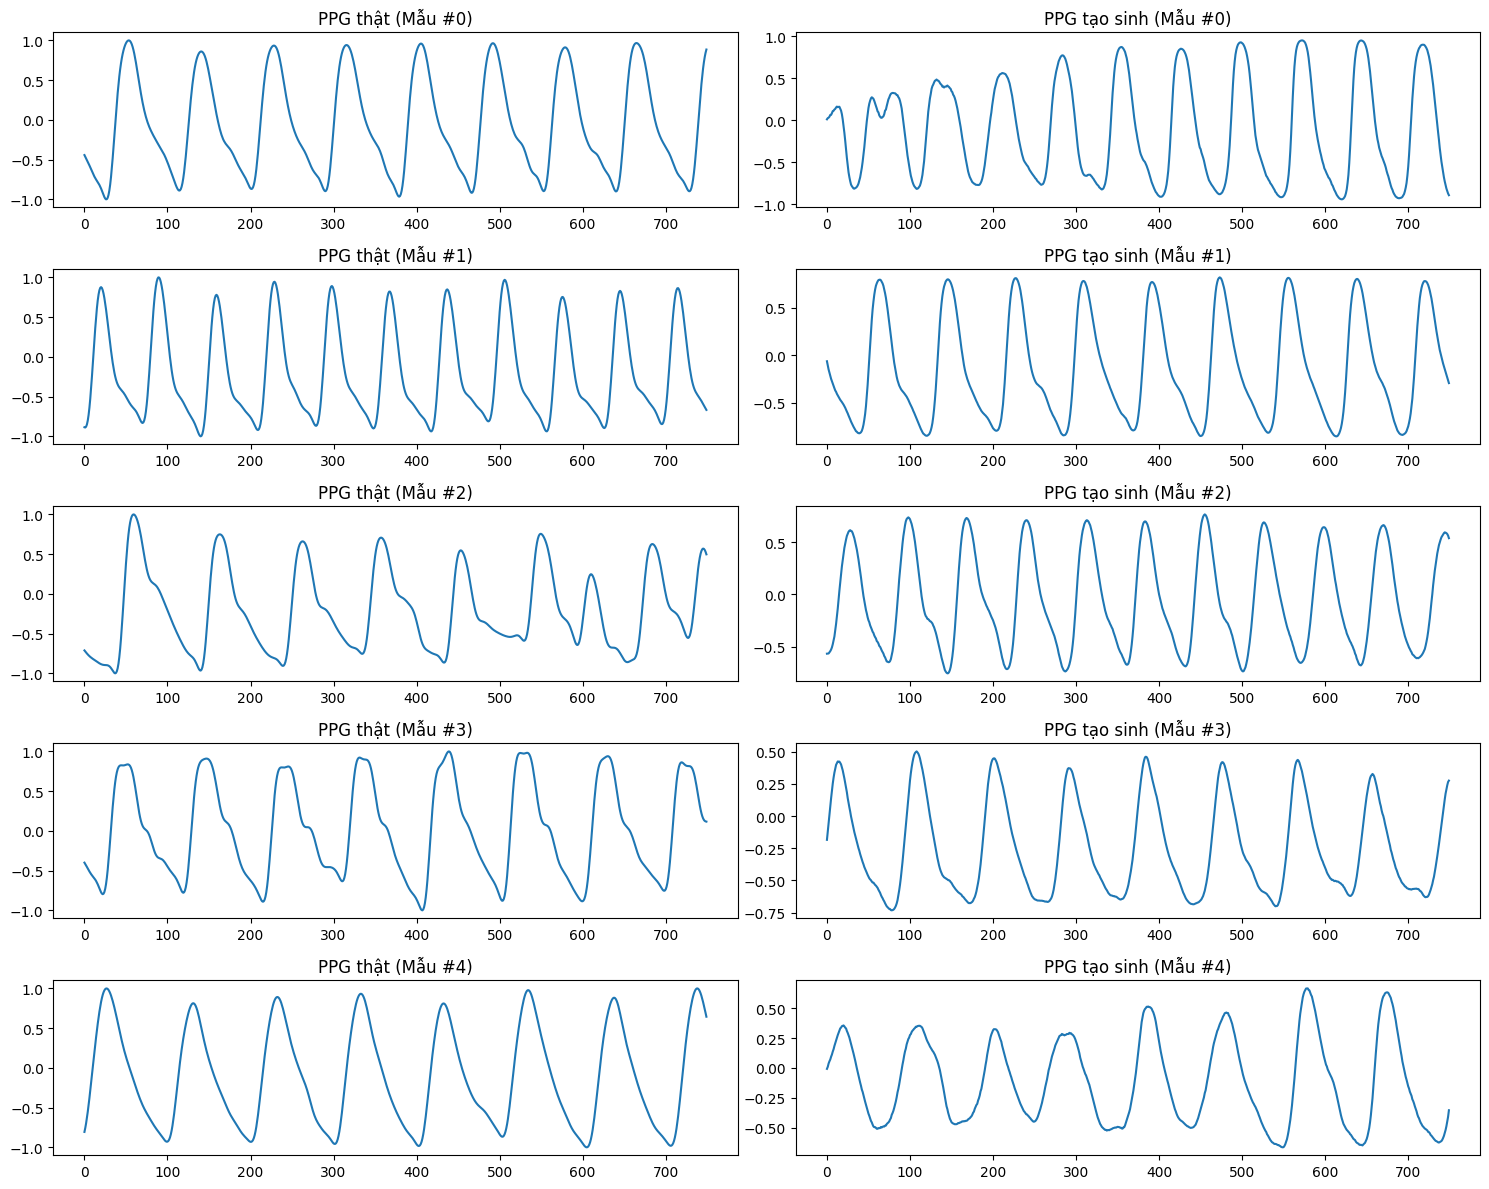

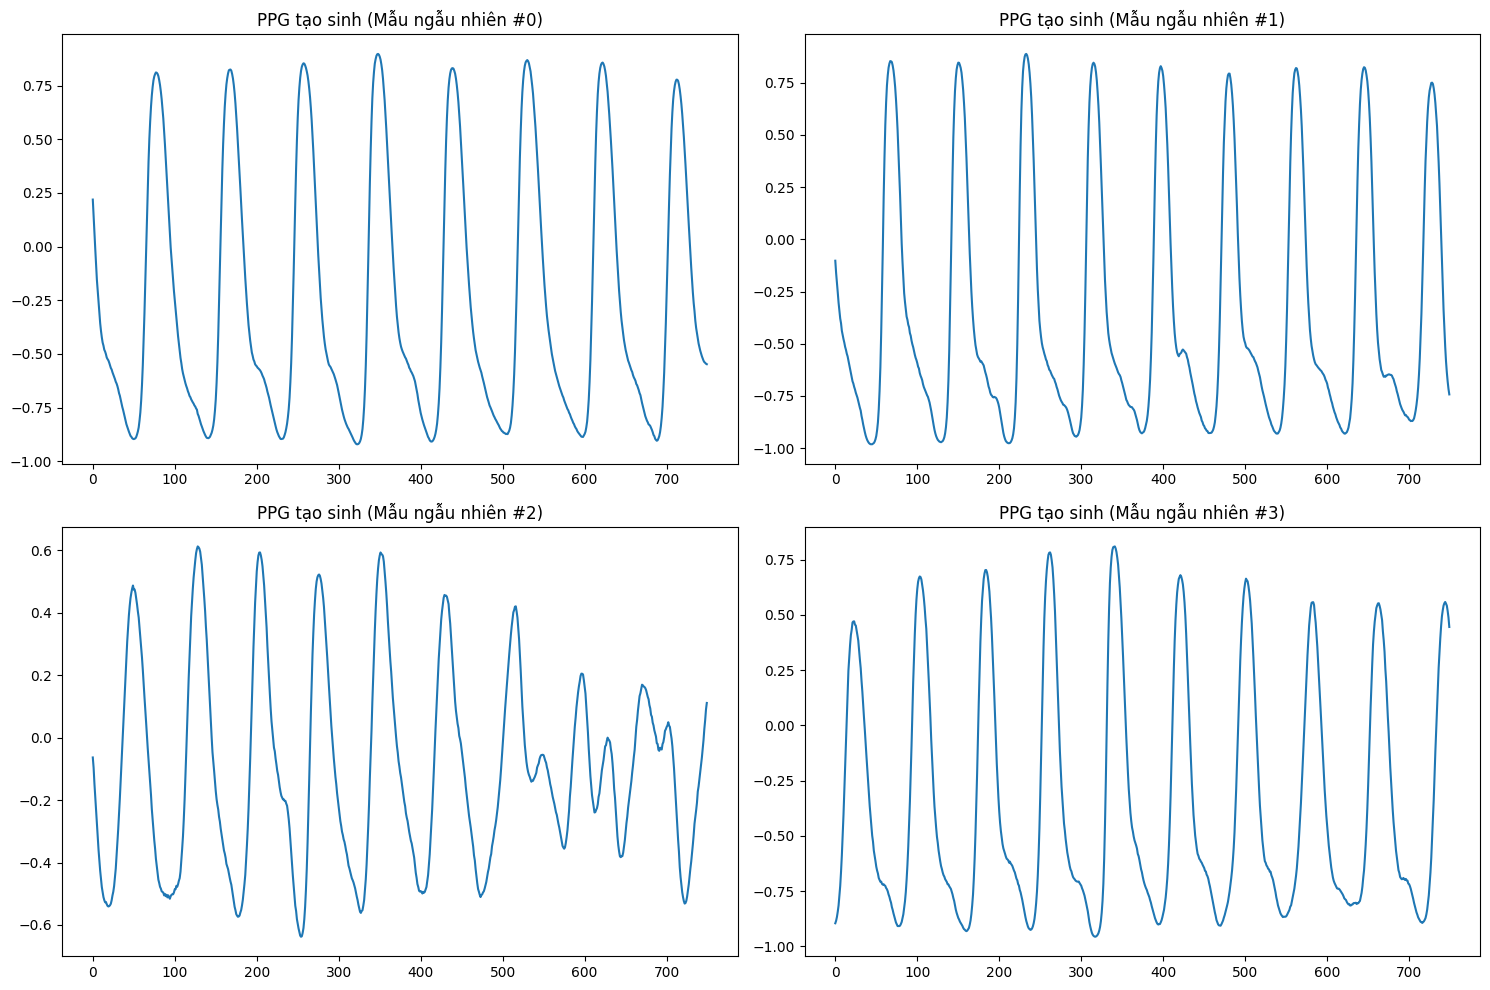

In [34]:
# Hàm đánh giá và tạo sinh PPG
def evaluate_generation(vae, device):
    """
    Tạo sinh PPG ngẫu nhiên

    Args:
        vae: mô hình VAE đã huấn luyện
        device: thiết bị tính toán (CPU/GPU)

    Returns:
        generated: tín hiệu PPG được tạo sinh
    """
    vae.eval()
    with torch.no_grad():
        z = torch.randn(1, latent_dim).to(device)
        generated = vae.decoder(z)
    return generated

# Lấy một số mẫu từ tập test để so sánh
n_samples = 5
test_samples = []

# Lấy một số mẫu từ tập test
for i, (data,) in enumerate(test_loader):
    if i >= n_samples:
        break
    test_samples.append(data[0])

# Tạo sinh PPG ngẫu nhiên
generated_samples = []
for _ in range(n_samples):
    generated = evaluate_generation(vae, device)
    generated_samples.append(generated.cpu().squeeze(0))

# Vẽ đồ thị so sánh giữa PPG thật và PPG tạo sinh
plt.figure(figsize=(15, 12))
for i in range(n_samples):
    # Vẽ PPG thật
    plt.subplot(n_samples, 2, 2*i+1)
    plt.plot(test_samples[i].cpu().numpy())
    plt.title(f'PPG thật (Mẫu #{i})')

    # Vẽ PPG tạo sinh
    plt.subplot(n_samples, 2, 2*i+2)
    plt.plot(generated_samples[i].numpy())
    plt.title(f'PPG tạo sinh (Mẫu #{i})')

plt.tight_layout()
plt.show()

# Tạo sinh PPG với các mẫu ngẫu nhiên
n_random_samples = 4
generated_random_samples = []
for _ in range(n_random_samples):
    generated = evaluate_generation(vae, device)
    generated_random_samples.append(generated.cpu().squeeze(0))

# Vẽ đồ thị PPG tạo sinh với các mẫu ngẫu nhiên
plt.figure(figsize=(15, 10))
for i in range(n_random_samples):
    plt.subplot(2, 2, i+1)
    plt.plot(generated_random_samples[i].numpy())
    plt.title(f'PPG tạo sinh (Mẫu ngẫu nhiên #{i})')

plt.tight_layout()
plt.show()